# Out of Home Advertisement Impression Prediction Project

In [343]:
#import libraries
import pandas as pd
import numpy as np
import gmplot
# For improved table display in the notebook
from IPython.display import display
from geopy.geocoders import Nominatim
from matplotlib import pyplot as plt
import folium
from folium.plugins import HeatMap
from haversine import haversine
import math
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.arima_model import ARIMA
from datetime import date, datetime, timedelta
import matplotlib
from fbprophet import Prophet
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [11]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [12]:
#read data
impressions_0 = pd.read_csv("impressions_000000000000.csv")
impressions_1 = pd.read_csv("impressions_000000000001.csv")

## Data Investigation

The column descriptions are as follows:<br>
impressions: device id<br>
mediaId: ad visual that represents a campaign<br>
timestamp, lat-lon: spatiotemporal information<br>
idType: device type (android or ios)


In [13]:
impressions_0.head()

,maid,idType,timestamp,lat,lon,mediaId
0,87c5f500-5056-4f9e-9042-f6ead405bc4d,adid,1568995146000,40.751830,-73.98759,02D09F56EBDEB6
1,20588d8c-80da-45e6-b53c-e6e7189eede9,adid,1569002549000,40.740906,-74.00546,02D09F56EBDEB6
2,66b3cac4-e7ab-43c9-9144-b819e6d46243,adid,1568939463000,34.072704,-117.79086,1424
3,4955d176-a4b9-49f8-b93d-28e18ae0313a,adid,1568940389000,34.273453,-118.36374,1424
4,8d98b0e8-baf2-4f81-b69d-9b64994307ac,adid,1569002013000,40.756615,-73.98680,02D09F56EBDEB6


In [14]:
impressions_0.shape

(4277636, 6)

In [15]:
impressions_0.dtypes

maid          object
idType        object
timestamp      int64
lat          float64
lon          float64
mediaId       object
dtype: object

In [16]:
impressions_1.head()

,maid,idType,timestamp,lat,lon,mediaId
0,c1e7399d-eccd-46be-b093-71653f873962,adid,1568991815000,34.061558,-118.344280,1424
1,d368a827-bcde-4144-bda8-7933805588c8,adid,1569008556000,33.959320,-118.287720,1424
2,64115e2d-5fa2-4df2-964f-6e19af3b5a5d,adid,1568954260000,34.050985,-118.264758,1424
3,b1d78907-682c-4e1e-82d6-54bc9d7b80eb,adid,1568942237000,33.731438,-117.832230,1424
4,652c456b-e76a-4622-9ec9-95c1675a9bab,adid,1568991606000,33.925533,-118.099780,1424


In [17]:
impressions_1.shape

(4284244, 6)

In [18]:
impressions_0.dtypes

maid          object
idType        object
timestamp      int64
lat          float64
lon          float64
mediaId       object
dtype: object

### Merge Files 

In [19]:
#merge two dataframes from files impressions_000000000000.csv and impressions_000000000001.csv 
impressions_0and1 = pd.concat([impressions_0,impressions_1]).reset_index(drop=True)

In [20]:
#impressions_0and1.to_csv('impressions_0and1.csv', index = None, header=True)

### Duplicate Check

In [21]:
impressions_0and1.shape

(8561880, 6)

In [22]:
impressions_0and1_unique=impressions_0and1.groupby(impressions_0and1.columns.tolist()).size().reset_index().rename(columns={0:'records'})

In [23]:
impressions_0and1_unique.shape

(1537067, 7)

In [24]:
impressions_0and1_unique.head()

,maid,idType,timestamp,lat,lon,mediaId,records
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,6
1,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817850,-118.002630,1424,5
2,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817857,-118.002630,1424,17
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,14
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,6


In [25]:
impressions_0and1_unique['records'].max()

38

In [26]:
impressions_0and1_unique.loc[(impressions_0and1_unique['records']==38)]

,maid,idType,timestamp,lat,lon,mediaId,records
304694,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F,38


In [27]:
impressions_0and1.loc[ ( impressions_0and1['maid']== "33058b72-1f90-4428-b232-423e0456d1b0" ) & ( impressions_0and1['timestamp']==1568741713000 ) ]

,maid,idType,timestamp,lat,lon,mediaId
96936,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
321011,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
347383,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
557126,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
574880,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
579305,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
785765,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
987437,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
1469321,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F
1794377,33058b72-1f90-4428-b232-423e0456d1b0,idfa,1568741713000,40.7145,-74.0029,0494A8BDA6898F


In [28]:
impressions_0and1_unique=impressions_0and1_unique.drop(['records'],axis=1)

### Investigate null values

In [29]:
impressions_0and1_unique.isna().sum()

maid         0
idType       0
timestamp    0
lat          0
lon          0
mediaId      0
dtype: int64

### Investigate Fraud Impressions and MediaId Errors 

In [30]:
#investigate impressions assigned to more than one idType
impression_id_count=impressions_0and1_unique.groupby("maid")["idType"].nunique().to_frame()

In [31]:
impression_id_count.head()

,idType
maid,
00003f94-b688-4969-bd7a-42f9e9a82701,1
0000b601-def1-4508-9b90-c1696477f31c,1
0000cb76-89f4-426b-a29f-30ea030bf2bc,1
00010df2-85b6-4572-80d2-c0d177df69be,1
00013817-6d7a-44d7-aa2b-b389a80aff36,1


In [32]:
impression_id_count['idType'].value_counts()

1    273884
2      3777
Name: idType, dtype: int64

In [33]:
#investigate impressions appearing in more than one place at the same time
impressions_0and1_unique ['maidandtime']=impressions_0and1_unique['maid'].map(str) + ' || '+impressions_0and1_unique['timestamp'].map(str)
impressions_0and1_unique ['latlon'] = impressions_0and1_unique['lat'].map(str) + ' || '+ impressions_0and1_unique['lon'].map(str)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [34]:
impressions_0and1_unique

,maid,idType,timestamp,lat,lon,mediaId,maidandtime,latlon
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001
1,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817850,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.81785 || -118.00263000000001
2,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.80381 || -117.94153999999999
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.803810999999996 || -117.941547
...,...,...,...,...,...,...,...,...
1537062,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342006000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867
1537063,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342041000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867
1537064,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342049000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867
1537065,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342093000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867


In [35]:
impressionandtime_latlon_count=impressions_0and1_unique.groupby("maidandtime")["latlon"].nunique().to_frame()

In [36]:
impressionandtime_latlon_count.head()

,latlon
maidandtime,
00003f94-b688-4969-bd7a-42f9e9a82701 || 1568963702000,1
00003f94-b688-4969-bd7a-42f9e9a82701 || 1568963718000,2
00003f94-b688-4969-bd7a-42f9e9a82701 || 1569016336000,2
00003f94-b688-4969-bd7a-42f9e9a82701 || 1569455971000,1
00003f94-b688-4969-bd7a-42f9e9a82701 || 1569550882000,1


In [37]:
impressionandtime_latlon_count['latlon'].value_counts()

1    923360
2    232077
3     46740
4      1518
5        36
Name: latlon, dtype: int64

In [38]:
impressionandtime_latlon_count.loc[(impressionandtime_latlon_count['latlon']>1)]['latlon'].count()

280371

In [39]:
impressionandtime_latlon_count.loc[(impressionandtime_latlon_count['latlon']>4)].head()

,latlon
maidandtime,
0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 1569424183000,5
2f8cbf0f-fc66-44b7-b759-5ca295303b93 || 1569202514000,5
33dd820d-3022-46c5-9af2-00da5422f949 || 1569324048000,5
35915d88-d1a0-45ba-90da-6e3c941eebb3 || 1569256692000,5
3907d5e0-a1a8-4d40-af1d-2985cf1b930b || 1568820316000,5


In [40]:
impressions_0and1_unique.loc[(impressions_0and1_unique['maidandtime']=='0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 1569424183000')]

,maid,idType,timestamp,lat,lon,mediaId,maidandtime,latlon
93275,0f95aa16-686d-4ccb-9d1f-2e89954ad947,adid,1569424183000,34.055540,-118.256970,1424,0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 156942...,34.05554 || -118.25697
93276,0f95aa16-686d-4ccb-9d1f-2e89954ad947,adid,1569424183000,34.055550,-118.256970,1424,0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 156942...,34.05555 || -118.25697
93277,0f95aa16-686d-4ccb-9d1f-2e89954ad947,adid,1569424183000,34.055557,-118.256970,1424,0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 156942...,34.055557 || -118.25697
93278,0f95aa16-686d-4ccb-9d1f-2e89954ad947,idfa,1569424183000,34.055557,-118.256972,1424,0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 156942...,34.055557 || -118.25697199999999
93279,0f95aa16-686d-4ccb-9d1f-2e89954ad947,idfa,1569424183000,34.055557,-118.256970,1424,0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 156942...,34.055557 || -118.25697
93280,0f95aa16-686d-4ccb-9d1f-2e89954ad947,idfa,1569424183000,34.055557,-118.256972,1424,0f95aa16-686d-4ccb-9d1f-2e89954ad947 || 156942...,34.055557184099996 || -118.2569715399


In [41]:
haversine((34.055540,-118.256970),(34.055557,-118.256972))

0.001899274520087651

Very close coordinates such as a few meters apart are reported so this should not be a problem. This could be fixed by rounding the floats lat and lon to less significant digits.

In [42]:
haversine( (34.055540,-118.256970),( float("{0:.6g}".format(34.055540)), float("{0:.6g}".format(-118.256970)) ) )

0.005236525733184601

So if the coordinates are rounded to three significant decimal points, the distance between the rounded one and the original one is around 5 m, I think big enough to enclose small reporting errors and small enough to cause a problem, so that I can apply a rounding. 

In [43]:
impressions_0and1_unique ['latlon_rounded'] = impression_0and1_unique['lat'].map(lambda x: '{:.06g}'.format(x)) + ' || '+ impressions_0and1_unique['lon'].map(lambda x: '{:.06g}'.format(x))

In [44]:
impressions_0and1_unique

,maid,idType,timestamp,lat,lon,mediaId,maidandtime,latlon,latlon_rounded
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003
1,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817850,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.81785 || -118.00263000000001,33.8178 || -118.003
2,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.80381 || -117.94153999999999,33.8038 || -117.942
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.803810999999996 || -117.941547,33.8038 || -117.942
...,...,...,...,...,...,...,...,...,...
1537062,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342006000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867,40.7105 || -74.0163
1537063,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342041000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867,40.7105 || -74.0163
1537064,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342049000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867,40.7105 || -74.0163
1537065,fffff22c-2ed7-4a83-8894-a241756ee3aa,adid,1569342093000,40.710499,-74.016296,02D09F56EBDEB6,fffff22c-2ed7-4a83-8894-a241756ee3aa || 156934...,40.7104988098 || -74.0162963867,40.7105 || -74.0163


In [45]:
impressionandtime_latlon_count=impressions_0and1_unique.groupby("maidandtime")["latlon_rounded"].nunique().to_frame()

In [46]:
impressionandtime_latlon_count['latlon_rounded'].value_counts()

1    1183645
2      19928
3        158
Name: latlon_rounded, dtype: int64

In [47]:
impressionandtime_latlon_count.loc[(impressionandtime_latlon_count['latlon_rounded']>1)]['latlon_rounded'].count()

20086

In [48]:
impressionandtime_latlon_count.loc[impressionandtime_latlon_count['latlon_rounded']>2)].head()

,latlon_rounded
maidandtime,
022bf9e1-3a3c-4996-acd8-b399228cd22a || 1568811973000,3
0420d192-73fd-4f27-bfcf-b5ab312b0d82 || 1569238341000,3
0420d192-73fd-4f27-bfcf-b5ab312b0d82 || 1569238349000,3
0520b20d-ce0f-49ed-be35-2ecd15612972 || 1569250479000,3
0520b20d-ce0f-49ed-be35-2ecd15612972 || 1569250487000,3


In [49]:
impressions_0and1_unique.loc[(impressions_0and1_unique['maidandtime']=='0420d192-73fd-4f27-bfcf-b5ab312b0d82 || 1569238341000')]

,maid,idType,timestamp,lat,lon,mediaId,maidandtime,latlon,latlon_rounded
24134,0420d192-73fd-4f27-bfcf-b5ab312b0d82,idfa,1569238341000,40.761250,-73.970040,0494A8BDA6898F,0420d192-73fd-4f27-bfcf-b5ab312b0d82 || 156923...,40.76125 || -73.97004,40.7612 || -73.97
24135,0420d192-73fd-4f27-bfcf-b5ab312b0d82,idfa,1569238341000,40.761256,-73.970048,0494A8BDA6898F,0420d192-73fd-4f27-bfcf-b5ab312b0d82 || 156923...,40.761256 || -73.97004799999999,40.7613 || -73.97
24136,0420d192-73fd-4f27-bfcf-b5ab312b0d82,idfa,1569238341000,40.761257,-73.970050,0494A8BDA6898F,0420d192-73fd-4f27-bfcf-b5ab312b0d82 || 156923...,40.761257 || -73.97005,40.7613 || -73.9701


In [50]:
haversine((40.761250,-73.970040),(40.761257,-73.970050))

0.001146825351640182

So the distance is long enough to constitute a problem, the 20086 pairs will be removed.

In [51]:
#investigate impressions exposed to more than one mediaid at the same place and at the same time

In [52]:
impressions_0and1_unique ['maidandtimespatiotemporal']=impressions_0and1_unique['maidandtime'].map(str) + ' || '+ maids_0and1_unique['latlon'].map(str)

In [53]:
maidandtimespatiotemporal_mediaId_count=impressions_0and1_unique.groupby("maidandtimespatiotemporal")["mediaId"].nunique().to_frame()

In [54]:
maidandtimespatiotemporal_mediaId_count.head()

,mediaId
maidandtimespatiotemporal,
00003f94-b688-4969-bd7a-42f9e9a82701 || 1568963702000 || 33.817857000000004 || -118.00263000000001,1
00003f94-b688-4969-bd7a-42f9e9a82701 || 1568963718000 || 33.81785 || -118.00263000000001,1
00003f94-b688-4969-bd7a-42f9e9a82701 || 1568963718000 || 33.817857000000004 || -118.00263000000001,1
00003f94-b688-4969-bd7a-42f9e9a82701 || 1569016336000 || 33.80381 || -117.94153999999999,1
00003f94-b688-4969-bd7a-42f9e9a82701 || 1569016336000 || 33.803810999999996 || -117.941547,1


In [55]:
maidandtimespatiotemporal_mediaId_count.loc[(maidandtimespatiotemporal_mediaId_count['mediaId']>1)]['mediaId'].count()

1163

In [56]:
maidandtimespatiotemporal_mediaId_count['mediaId'].value_counts()

1    1532823
2       1163
Name: mediaId, dtype: int64

### Remove Problematic Entries 

In [57]:
#drop rows for impressions assigned to more than one idType

In [58]:
maid_id_count.shape

(277661, 1)

In [59]:
maid_id_count.drop( maid_id_count [maid_id_count['idType']==1].index, inplace=True)

In [60]:
maid_id_count.shape

(3777, 1)

In [61]:
#drop rows for impressions appearing in more than one place at the same time

In [62]:
maidandtime_latlon_count.drop( maidandtime_latlon_count [maidandtime_latlon_count['latlon_rounded']==1].index, inplace=True)

In [63]:
maidandtime_latlon_count.shape

(20086, 1)

In [64]:
#drop rows for impressions exposed to more than one mediaid at the same place and at the same time
#thinking that this is wrong data as 120ft hourglass view shed is small enough to exclude the probability of two ads exposed from multiple rides

In [65]:
maidandtimespatiotemporal_mediaId_count.shape

(1533986, 1)

In [66]:
maidandtimespatiotemporal_mediaId_count.drop( maidandtimespatiotemporal_mediaId_count [maidandtimespatiotemporal_mediaId_count['mediaId']==1].index, inplace=True)

In [67]:
maidandtimespatiotemporal_mediaId_count.shape

(1163, 1)

#### Drop Unwanted Rows

In [68]:
maids_0and1_unique.head()

,maid,idType,timestamp,lat,lon,mediaId,maidandtime,latlon,latlon_rounded,maidandtimespatiotemporal
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...
1,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817850,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.81785 || -118.00263000000001,33.8178 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...
2,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.80381 || -117.94153999999999,33.8038 || -117.942,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.803810999999996 || -117.941547,33.8038 || -117.942,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...


In [69]:
maids_0and1_unique.shape

(1537067, 10)

In [70]:
#impressions_0and1_unique join maid_id_count
j1=pd.merge(maids_0and1_unique,maid_id_count,left_on='maid',right_on='maid',how='left')

In [71]:
j1.shape

(1537067, 11)

In [72]:
j1.head()

,maid,idType_x,timestamp,lat,lon,mediaId,maidandtime,latlon,latlon_rounded,maidandtimespatiotemporal,idType_y
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,NaN
1,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817850,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.81785 || -118.00263000000001,33.8178 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,NaN
2,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,NaN
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.80381 || -117.94153999999999,33.8038 || -117.942,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,NaN
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.803810999999996 || -117.941547,33.8038 || -117.942,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,NaN


In [73]:
#maids_0and1_unique join maid_id_count
j2=pd.merge(j1,maidandtime_latlon_count,left_on='maidandtime',right_on='maidandtime',how='left')

In [74]:
j2.shape

(1537067, 12)

In [75]:
#maids_0and1_unique join maid_id_count
j3=pd.merge(j2,maidandtimespatiotemporal_mediaId_count,left_on='maidandtimespatiotemporal',right_on='maidandtimespatiotemporal',how='left')

In [76]:
j3.shape

(1537067, 13)

In [77]:
j3.head(100)

,maid,idType_x,timestamp,lat,lon,mediaId_x,maidandtime,latlon,latlon_rounded_x,maidandtimespatiotemporal,idType_y,latlon_rounded_y,mediaId_y
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,NaN,NaN,NaN
1,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817850,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.81785 || -118.00263000000001,33.8178 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,NaN,2.0,NaN
2,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963718000,33.817857,-118.002630,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,33.817857000000004 || -118.00263000000001,33.8179 || -118.003,00003f94-b688-4969-bd7a-42f9e9a82701 || 156896...,NaN,2.0,NaN
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.80381 || -117.94153999999999,33.8038 || -117.942,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,NaN,NaN,NaN
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,33.803810999999996 || -117.941547,33.8038 || -117.942,00003f94-b688-4969-bd7a-42f9e9a82701 || 156901...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0006ecb6-93a1-49a8-b1b6-f17ab71bf985,idfa,1569198776000,33.876724,-118.179040,1424,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,33.876723999999996 || -118.17903999999999,33.8767 || -118.179,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,NaN,NaN,NaN
96,0006ecb6-93a1-49a8-b1b6-f17ab71bf985,idfa,1569198776000,33.876725,-118.179038,1424,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,33.876725 || -118.17903799999999,33.8767 || -118.179,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,NaN,NaN,NaN
97,0006ecb6-93a1-49a8-b1b6-f17ab71bf985,idfa,1569198842000,33.876609,-118.171578,1424,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,33.876609 || -118.171578,33.8766 || -118.172,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,NaN,NaN,NaN
98,0006ecb6-93a1-49a8-b1b6-f17ab71bf985,idfa,1569198842000,33.876610,-118.171580,1424,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,33.87661 || -118.17158,33.8766 || -118.172,0006ecb6-93a1-49a8-b1b6-f17ab71bf985 || 156919...,NaN,NaN,NaN


In [78]:
j3=j3.fillna(0)

In [79]:
j3.groupby('idType_y').nunique()

,maid,idType_x,timestamp,lat,lon,mediaId_x,maidandtime,latlon,latlon_rounded_x,maidandtimespatiotemporal,idType_y,latlon_rounded_y,mediaId_y
idType_y,,,,,,,,,,,,,
0.0,273884,2,564713,510830,465288,3,1190071,943563,233037,1513235,1,3,2
2.0,3777,2,12262,11465,11000,3,13660,12679,4758,20751,1,3,2


In [80]:
j3['idType_y'].value_counts()

0.0    1514388
2.0      22679
Name: idType_y, dtype: int64

In [81]:
j3.dtypes

maid                          object
idType_x                      object
timestamp                      int64
lat                          float64
lon                          float64
mediaId_x                     object
maidandtime                   object
latlon                        object
latlon_rounded_x              object
maidandtimespatiotemporal     object
idType_y                     float64
latlon_rounded_y             float64
mediaId_y                    float64
dtype: object

In [82]:
j3.drop( j3 [ j3['idType_y']>1  ].index, inplace=True)

In [83]:
j3.shape

(1514388, 13)

In [84]:
j3['latlon_rounded_y'].value_counts()

0.0    1469374
2.0      44525
3.0        489
Name: latlon_rounded_y, dtype: int64

In [85]:
j3.drop( j3 [ j3['latlon_rounded_y']>1  ].index, inplace=True)

In [86]:
j3.shape

(1469374, 13)

In [87]:
j3['mediaId_y'].value_counts()

0.0    1467150
2.0       2224
Name: mediaId_y, dtype: int64

In [88]:
j3.drop( j3 [ j3['mediaId_y']>1  ].index, inplace=True)

In [89]:
j3.shape

(1467150, 13)

In [90]:
j3.drop(['idType_y','latlon_rounded_y','mediaId_y','maidandtime','maidandtimespatiotemporal','latlon_rounded_x','latlon'],axis=1,inplace=True)

In [91]:
j3.shape

(1467150, 6)

In [92]:
j3.dtypes

maid          object
idType_x      object
timestamp      int64
lat          float64
lon          float64
mediaId_x     object
dtype: object

In [93]:
maids_0and1_unique=j3
maids_0and1_unique.rename(columns={"idType_x": "idType", "mediaId_x": "mediaId"},inplace=True)

## Investigate Column Values and Distributions

In [94]:
maids_0and1_unique.dtypes

maid          object
idType        object
timestamp      int64
lat          float64
lon          float64
mediaId       object
dtype: object

In [95]:
#investigate idType s
print(maids_0and1_unique.groupby('idType').count())

          maid  timestamp     lat     lon  mediaId
idType                                            
adid    568052     568052  568052  568052   568052
idfa    899098     899098  899098  899098   899098


In [96]:
maids_0and1_unique.groupby('idType').nunique()

,maid,idType,timestamp,lat,lon,mediaId
idType,,,,,,
adid,113759,1,303657,243645,212277,3
idfa,158650,1,403227,314313,293420,3


In [97]:
#investigate timestamps
maids_0and1_unique['datetime'] = pd.to_datetime ( maids_0and1_unique['timestamp'], unit='ms')
maids_0and1_unique.head()

,maid,idType,timestamp,lat,lon,mediaId,datetime
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22


In [98]:
maids_0and1_unique['date'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).date
maids_0and1_unique['time'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).time

maids_0and1_unique['year'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).year
maids_0and1_unique['month'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).month
maids_0and1_unique['day'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).day
maids_0and1_unique['hour'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).hour
maids_0and1_unique['minute'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).minute
maids_0and1_unique['second'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).second
maids_0and1_unique['weekday'] = pd.DatetimeIndex(maids_0and1_unique['datetime']).weekday
maids_0and1_unique['weekofyear'] = maids_0and1_unique['datetime'].apply(lambda x: str(x.isocalendar()[1]).zfill(2))
maids_0and1_unique.head()

#September 2, 2019 is labor day in USA.

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02,2019-09-20,07:15:02,2019,9,20,7,15,2,4,38
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,9,20,21,52,16,4,38
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,9,20,21,52,16,4,38
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31,2019-09-25,23:59:31,2019,9,25,23,59,31,2,39
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22,2019-09-27,02:21:22,2019,9,27,2,21,22,4,39


In [99]:
maids_0and1_unique.shape

(1467150, 17)

In [100]:
print (maids_0and1_unique['datetime'].min())
print (maids_0and1_unique['datetime'].max())

2019-09-10 11:05:05
2019-09-28 22:52:02


In [101]:
#investigate mediaId s
maids_0and1_unique.groupby('mediaId').nunique()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear
mediaId,,,,,,,,,,,,,,,,,
02D09F56EBDEB6,81372,2,211847,155012,146159,1,211847,12,55677,1,1,12,8,60,60,7,2
0494A8BDA6898F,96425,2,186116,131960,125091,1,186116,15,39679,1,1,15,8,60,60,7,3
1424,120148,2,276982,239960,205697,1,276982,11,95708,1,1,11,24,60,60,7,2


In [102]:
#investigate lat-lon
print (maids_0and1_unique['lat'].min())
print (maids_0and1_unique['lat'].max())
print (maids_0and1_unique['lon'].min())
print (maids_0and1_unique['lon'].max())

32.533232
41.112064000000004
-122.48768329999999
-73.59206999999999


In [103]:
maids_0and1_unique_latlons = maids_0and1_unique[['lat','lon']].groupby((['lat','lon'])).size().reset_index().rename(columns={0:'latlonrecords'})

In [104]:
maids_0and1_unique_latlons.head()

,lat,lon,latlonrecords
0,32.533232,-117.022905,1
1,32.533251,-117.022933,1
2,32.534941,-117.025623,1
3,32.534968,-117.025666,1
4,32.534996,-117.025714,1


In [105]:
maids_0and1_unique_latlons['latlonrecords'].max()

23409

In [106]:
maids_0and1_unique_latlons.shape

(917449, 3)

(array([8.76008e+05, 2.37420e+04, 7.99000e+03, 4.74300e+03, 1.39000e+03,
        9.14000e+02, 7.72000e+02, 3.16000e+02, 2.41000e+02, 2.69000e+02]),
 array([ 1. ,  3.3,  5.6,  7.9, 10.2, 12.5, 14.8, 17.1, 19.4, 21.7, 24. ]),
 <a list of 10 Patch objects>)

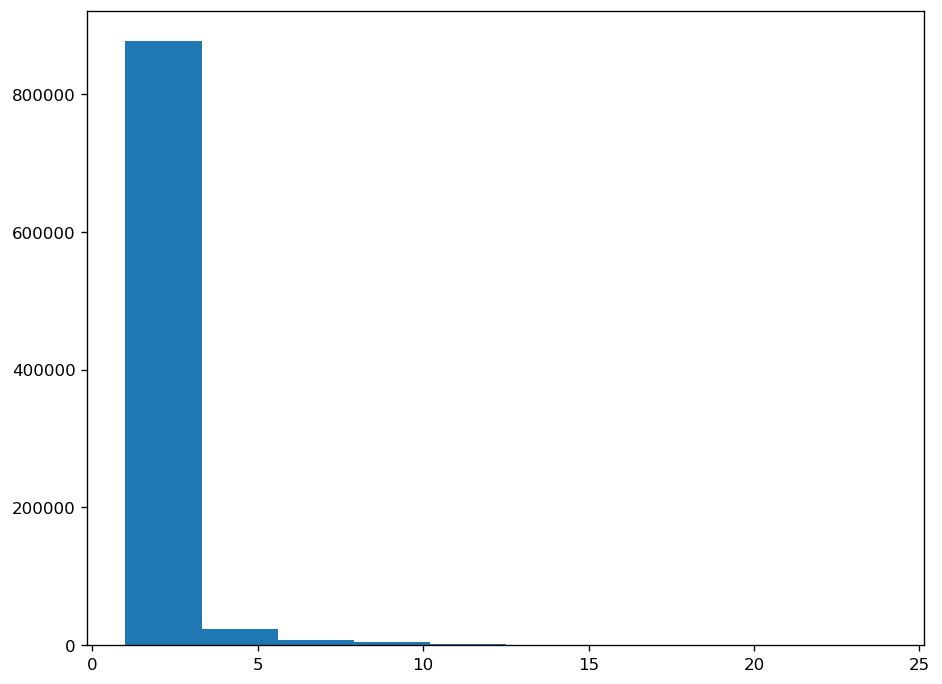

In [107]:
plt.hist(maids_0and1_unique_latlons['latlonrecords'].loc[ (maids_0and1_unique_latlons['latlonrecords'] < 25) ] )

In [108]:
maids_0and1_unique_latlons['latlonrecords'].loc[ (maids_0and1_unique_latlons['latlonrecords'] < 25) ].shape

(916385,)

In [109]:
toplocations = maids_0and1_unique_latlons.sort_values(by=['latlonrecords'], ascending=False).head(1000)

In [110]:
toplocations.head()

,lat,lon,latlonrecords
382175,40.71450,-74.002900,23409
850496,40.76830,-73.980200,7402
382692,40.71450,-74.002899,7215
473359,40.73873,-74.003650,4602
123422,34.00680,-118.256000,4239


In [111]:
#geolocator = Nominatim(user_agent="myGeocoder")
#location = geolocator.reverse("40.71450, -74.002900")
#print(location.raw)

In [112]:
#toplocations10=toplocations.head(10)

In [113]:
def get_county(row):
    pos = str(row['lat']) + ', ' + str(row['lon'])
    geolocator = Nominatim(user_agent="myGeocoder")
    locations = geolocator.reverse(pos, timeout = 10)

    return locations.raw.get('address').get('county')


In [114]:
#toplocations10['county'] = toplocations10.apply(lambda row: get_county(row), axis = 1)

In [115]:
#toplocations10

In [116]:
#toplocations['county'] = toplocations.apply(lambda row: get_county(row), axis = 1)

In [117]:
#toplocations.to_csv ('toplocations_county.csv', index = None, header=True)
toplocations = pd.read_csv("toplocations_county.csv")

In [118]:
toplocations.head(20)

,lat,lon,latlonrecords,county
0,40.714500,-74.002900,23268,New York County
1,40.768300,-73.980200,7366,New York County
2,40.714500,-74.002899,5993,New York County
3,40.738730,-74.003650,4602,New York County
4,34.006800,-118.256000,4221,Los Angeles County
5,40.765300,-73.958900,2494,New York County
6,40.735900,-73.990400,2375,New York County
7,33.955500,-118.286300,2334,Los Angeles County
8,40.780900,-73.950200,2035,New York County
9,34.029000,-118.400500,1972,Los Angeles County


In [119]:
topcounties = toplocations.groupby(['county'])['latlonrecords'].sum().reset_index()
topcounties = topcounties.sort_values(by=['latlonrecords'], ascending=False)
topcounties

,county,latlonrecords
4,New York County,88810
3,Los Angeles County,43732
5,Orange County,1661
6,Queens County,1609
1,Bronx County,814
2,Kings County,609
8,San Bernardino County,420
7,Riverside County,166
9,San Diego County,26
0,Bergen County,19


In [120]:
#toplocations_city = pd.read_csv("toplocation_cities.csv")
#topcities = toplocations_city.groupby(['city'])['latlonrecords'].sum().reset_index()

In [121]:
#topcities = topcities.sort_values(by=['latlonrecords'], ascending=False)
#topcities

In [122]:
map_NY = folium.Map(location=[40.71450,-74.002900],
                    zoom_start = 13)

heat_ny_df = toplocations[toplocations['county']=="New York County"]

heat_data_ny = [[row['lat'],row['lon']] for index, row in heat_ny_df.iterrows()]

# Plot it on the map
HeatMap(heat_data_ny).add_to(map_NY)

# Display the map
map_NY

In [123]:
map_LA = folium.Map(location=[34.00680,-118.256000],
                    zoom_start = 13) 

heat_la_df = toplocations[toplocations['county']=="Los Angeles County"]

heat_data_la = [[row['lat'],row['lon']] for index, row in heat_la_df.iterrows()]

# Plot it on the map
HeatMap(heat_data_la).add_to(map_LA)

# Display the map
map_LA

### Locations Based on Lat Lon Bounding Box

In [124]:
#Using the tool on https://boundingbox.klokantech.com/, 
#New York is between coordinates $$c(W 75°34'00"--W 71°26'00"/N 41°34'00"--N 39°52'00")
#San Francisco is between coordinates $$c(W 126°02'00"--W 116°58'00"/N 40°03'00"--N 35°40'00")
#Los Angeles is between coordinates $$c(W 121°42'00"--W 113°39'00"/N 35°40'00"--N 32°23'00")

In [125]:
def bounding_city(s):
    if ( abs(s['lon']) <= 75.3400 and abs(s['lon']) >= 71.2600 and (abs(s['lat']) <= 41.3400) and (abs(s['lat']) >= 39.5200) ):
        return 'New York'
    elif (abs(s['lon']) <= 126.0200 and abs(s['lon']) >= 116.5800 and (abs(s['lat']) <= 40.0300) and (abs(s['lat']) >= 35.4000) ):
        return 'San Francisco'
    elif (abs(s['lon']) <= 121.4200 and abs(s['lon']) >= 113.3900 and (abs(s['lat']) < 35.4000) and (abs(s['lat']) >= 32.2300) ):
        return 'Los Angeles'
    else:
        return 'Unknown'

maids_0and1_unique['bounding_city']=maids_0and1_unique.apply(bounding_city,axis=1)

In [126]:
maids_0and1_unique.head(20)

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear,bounding_city
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02,2019-09-20,07:15:02,2019,9,20,7,15,2,4,38,Los Angeles
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,9,20,21,52,16,4,38,Los Angeles
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,9,20,21,52,16,4,38,Los Angeles
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31,2019-09-25,23:59:31,2019,9,25,23,59,31,2,39,Los Angeles
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22,2019-09-27,02:21:22,2019,9,27,2,21,22,4,39,Los Angeles
7,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550894000,33.817790,-118.002637,1424,2019-09-27 02:21:34,2019-09-27,02:21:34,2019,9,27,2,21,34,4,39,Los Angeles
8,0000b601-def1-4508-9b90-c1696477f31c,idfa,1569338467000,40.714500,-74.002899,02D09F56EBDEB6,2019-09-24 15:21:07,2019-09-24,15:21:07,2019,9,24,15,21,7,1,39,New York
9,0000b601-def1-4508-9b90-c1696477f31c,idfa,1569338475000,40.714500,-74.002899,02D09F56EBDEB6,2019-09-24 15:21:15,2019-09-24,15:21:15,2019,9,24,15,21,15,1,39,New York
10,0000cb76-89f4-426b-a29f-30ea030bf2bc,adid,1569356043000,34.062107,-118.236670,1424,2019-09-24 20:14:03,2019-09-24,20:14:03,2019,9,24,20,14,3,1,39,Los Angeles
11,0000cb76-89f4-426b-a29f-30ea030bf2bc,adid,1569356043000,34.062108,-118.236674,1424,2019-09-24 20:14:03,2019-09-24,20:14:03,2019,9,24,20,14,3,1,39,Los Angeles


In [127]:
maids_0and1_unique.groupby('bounding_city').nunique()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear,bounding_city
bounding_city,,,,,,,,,,,,,,,,,,
Los Angeles,120005,2,276853,239674,205437,1,276853,11,95700,1,1,11,24,60,60,7,2,1
New York,152591,2,332016,260404,249967,2,332016,19,69819,1,1,19,8,60,60,7,3,1
San Francisco,101,2,160,171,168,1,160,8,160,1,1,8,17,54,56,7,2,1
Unknown,56,2,120,125,102,2,120,3,120,1,1,3,8,34,52,3,2,1


In [128]:
maids_0and1_unique.groupby('bounding_city').count()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear
bounding_city,,,,,,,,,,,,,,,,,
Los Angeles,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020,502020
New York,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750,964750
San Francisco,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216,216
Unknown,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164,164


In [129]:
maids_0and1_unique.groupby(['bounding_city','mediaId']).nunique()

maid  idType  timestamp     lat     lon  \
bounding_city mediaId                                                     
Los Angeles   1424            120005       2     276853  239674  205437   
New York      02D09F56EBDEB6   81372       2     211847  155012  146159   
              0494A8BDA6898F   96420       2     186111  131950  125081   
San Francisco 1424               101       2        160     171     168   
Unknown       0494A8BDA6898F       5       1         13      10      10   
              1424                51       2        107     115      92   

                              mediaId  datetime  date   time  year  month  \
bounding_city mediaId                                                       
Los Angeles   1424                  1    276853    11  95700     1      1   
New York      02D09F56EBDEB6        1    211847    12  55677     1      1   
              0494A8BDA6898F        1    186111    15  39677     1      1   
San Francisco 1424                  1       160     8    160     1      1   
Unknown       0494A8BDA6898F        1        13     1     13     1      1   
              1424                  1       107     2    107     1      1   

                              day  hour  minute  second  weekday  weekofyear  \
bounding_city mediaId                                                          
Los Angeles   1424             11    24      60      60        7           2   
New York      02D09F56EBDEB6   12     8      60      60        7           2   
              0494A8BDA6898F   15     8      60      60        7           3   
San Francisco 1424              8    17      54      56        7           2   
Unknown       0494A8BDA6898F    1     3       6       7        1           1   
              1424              2     5      30      51        2           1   

                              bounding_city  
bounding_city mediaId                        
Los Angeles   1424                        1  
New York      02D09F56EBDEB6              1  
              0494A8BDA6898F              1  
San Francisco 1424                        1  
Unknown       0494A8BDA6898F              1  
              1424                        1

It is obvious above that my rough hand-scribed bounding boxes misses some bounding_cities, therefore I correct them based on other mediaId and bounding_city pairs.

In [130]:
def correct_bounding_city(s):
    if (s['bounding_city']=='Unknown') and (s['mediaId'] == '0494A8BDA6898F'):
        return 'New York' 
    elif( ((s['bounding_city']=='Unknown') or (s['bounding_city']=='San Francisco') )  and (s['mediaId'] == '1424') ):
        return 'Los Angeles'
    else:
        return s['bounding_city']

maids_0and1_unique['bounding_city_corr']=maids_0and1_unique.apply(correct_bounding_city,axis=1)

In [131]:
maids_0and1_unique.groupby(['bounding_city_corr','mediaId']).nunique()

maid  idType  timestamp     lat     lon  \
bounding_city_corr mediaId                                                     
Los Angeles        1424            120148       2     276982  239960  205697   
New York           02D09F56EBDEB6   81372       2     211847  155012  146159   
                   0494A8BDA6898F   96425       2     186116  131960  125091   

                                   mediaId  datetime  date   time  year  \
bounding_city_corr mediaId                                                
Los Angeles        1424                  1    276982    11  95708     1   
New York           02D09F56EBDEB6        1    211847    12  55677     1   
                   0494A8BDA6898F        1    186116    15  39679     1   

                                   month  day  hour  minute  second  weekday  \
bounding_city_corr mediaId                                                     
Los Angeles        1424                1   11    24      60      60        7   
New York           02D09F56EBDEB6      1   12     8      60      60        7   
                   0494A8BDA6898F      1   15     8      60      60        7   

                                   weekofyear  bounding_city  \
bounding_city_corr mediaId                                     
Los Angeles        1424                     2              3   
New York           02D09F56EBDEB6           2              1   
                   0494A8BDA6898F           3              2   

                                   bounding_city_corr  
bounding_city_corr mediaId                             
Los Angeles        1424                             1  
New York           02D09F56EBDEB6                   1  
                   0494A8BDA6898F                   1

In [132]:
maids_0and1_unique.groupby(['bounding_city_corr','mediaId']).count()

maid  idType  timestamp     lat     lon  \
bounding_city_corr mediaId                                                     
Los Angeles        1424            502387  502387     502387  502387  502387   
New York           02D09F56EBDEB6  557996  557996     557996  557996  557996   
                   0494A8BDA6898F  406767  406767     406767  406767  406767   

                                   datetime    date    time    year   month  \
bounding_city_corr mediaId                                                    
Los Angeles        1424              502387  502387  502387  502387  502387   
New York           02D09F56EBDEB6    557996  557996  557996  557996  557996   
                   0494A8BDA6898F    406767  406767  406767  406767  406767   

                                      day    hour  minute  second  weekday  \
bounding_city_corr mediaId                                                   
Los Angeles        1424            502387  502387  502387  502387   502387   
New York           02D09F56EBDEB6  557996  557996  557996  557996   557996   
                   0494A8BDA6898F  406767  406767  406767  406767   406767   

                                   weekofyear  bounding_city  
bounding_city_corr mediaId                                    
Los Angeles        1424                502387         502387  
New York           02D09F56EBDEB6      557996         557996  
                   0494A8BDA6898F      406767         406767

In [133]:
maids_0and1_unique.head()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02,2019-09-20,07:15:02,2019,9,20,7,15,2,4,38,Los Angeles,Los Angeles
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,9,20,21,52,16,4,38,Los Angeles,Los Angeles
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,9,20,21,52,16,4,38,Los Angeles,Los Angeles
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31,2019-09-25,23:59:31,2019,9,25,23,59,31,2,39,Los Angeles,Los Angeles
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22,2019-09-27,02:21:22,2019,9,27,2,21,22,4,39,Los Angeles,Los Angeles


### Investigate the MediaId's 

In [134]:
maids_0and1_unique.columns

Index(['maid', 'idType', 'timestamp', 'lat', 'lon', 'mediaId', 'datetime',
       'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'weekday', 'weekofyear', 'bounding_city', 'bounding_city_corr'],
      dtype='object')

In [135]:
#weekly exposed number of maids per campaign
count_weekly_maids = maids_0and1_unique.groupby(['mediaId','weekofyear']).agg({'maid':'count'})

In [136]:
count_weekly_maids

maid
mediaId        weekofyear        
02D09F56EBDEB6 38          291237
               39          266759
0494A8BDA6898F 37           94747
               38          243913
               39           68107
1424           38          256013
               39          246374

In [137]:
maids_0and1_unique.groupby(['weekofyear','date']).agg({'maid':'count'})

maid
weekofyear date              
37         2019-09-10   11476
           2019-09-11   16433
           2019-09-12   15493
           2019-09-13   19099
           2019-09-14   13194
           2019-09-15   19052
38         2019-09-16   35675
           2019-09-17   57537
           2019-09-18  124557
           2019-09-19  169848
           2019-09-20  160445
           2019-09-21  107182
           2019-09-22  135919
39         2019-09-23  185586
           2019-09-24  130208
           2019-09-25  107655
           2019-09-26   98739
           2019-09-27   51886
           2019-09-28    7166

In [138]:
#check the dates before the data quality operations to make sure no data is lost in terms of dates
maids_0and1.groupby(['mediaId']).agg({'timestamp':'min'})

,timestamp
mediaId,
02D09F56EBDEB6,1568718296000
0494A8BDA6898F,1568113505000
1424,1568842106000


In [139]:
maids_0and1_unique[maids_0and1_unique['timestamp']==1568718296000]

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr
82939,0defab5e-2526-43c3-9eb7-f1472af82f59,idfa,1568718296000,40.746840,-74.000790,02D09F56EBDEB6,2019-09-17 11:04:56,2019-09-17,11:04:56,2019,9,17,11,4,56,1,38,New York,New York
82940,0defab5e-2526-43c3-9eb7-f1472af82f59,idfa,1568718296000,40.746841,-74.000796,02D09F56EBDEB6,2019-09-17 11:04:56,2019-09-17,11:04:56,2019,9,17,11,4,56,1,38,New York,New York
1426714,ed786a57-4ff4-4dae-ae77-7cf779894192,idfa,1568718296000,40.746840,-74.000790,02D09F56EBDEB6,2019-09-17 11:04:56,2019-09-17,11:04:56,2019,9,17,11,4,56,1,38,New York,New York


In [140]:
maids_0and1_unique[maids_0and1_unique['timestamp']==1568113505000]

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr
457779,4d457485-b2dd-4fd7-89ea-51626fb42a1c,idfa,1568113505000,40.807144,-73.94052,0494A8BDA6898F,2019-09-10 11:05:05,2019-09-10,11:05:05,2019,9,10,11,5,5,1,37,New York,New York
1419992,ec5c3709-1267-49ba-a47d-15a60853f39d,idfa,1568113505000,40.807144,-73.94052,0494A8BDA6898F,2019-09-10 11:05:05,2019-09-10,11:05:05,2019,9,10,11,5,5,1,37,New York,New York


In [141]:
maids_0and1_unique[maids_0and1_unique['timestamp']==1568842106000]

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,month,day,hour,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr
604905,653b88db-a6ab-47a4-8615-f2289a4f77da,idfa,1568842106000,34.208435,-118.39400,1424,2019-09-18 21:28:26,2019-09-18,21:28:26,2019,9,18,21,28,26,2,38,Los Angeles,Los Angeles
1387842,e7003be6-9d76-45a5-8682-dcef7ffcaa95,idfa,1568842106000,34.208430,-118.39399,1424,2019-09-18 21:28:26,2019-09-18,21:28:26,2019,9,18,21,28,26,2,38,Los Angeles,Los Angeles


In [142]:
mediamax=maids_0and1.groupby(['mediaId']).agg({'timestamp':'max'})

In [143]:
mediamin=maids_0and1.groupby(['mediaId']).agg({'timestamp':'min'})

In [144]:
mediamax['datetime'] = pd.to_datetime ( mediamax['timestamp'], unit='ms')
mediamax

,timestamp,datetime
mediaId,,
02D09F56EBDEB6,1569693883000,2019-09-28 18:04:43
0494A8BDA6898F,1569325257000,2019-09-24 11:40:57
1424,1569711122000,2019-09-28 22:52:02


In [145]:
mediamin['datetime'] = pd.to_datetime ( mediamin['timestamp'], unit='ms')
mediamin

,timestamp,datetime
mediaId,,
02D09F56EBDEB6,1568718296000,2019-09-17 11:04:56
0494A8BDA6898F,1568113505000,2019-09-10 11:05:05
1424,1568842106000,2019-09-18 21:28:26


In [146]:
#split the dataset for each campaign
campaign_1424 = maids_0and1_unique.loc[(maids_0and1_unique['mediaId']=="1424")]
campaign_02D0 = maids_0and1_unique.loc[(maids_0and1_unique['mediaId']=="02D09F56EBDEB6")]
campaign_0494 = maids_0and1_unique.loc[(maids_0and1_unique['mediaId']=="0494A8BDA6898F")]

In [147]:
media_vs_day_count_02D0=campaign_02D0.groupby(['mediaId','date']).agg({'maid':'count'})
media_vs_day_count_02D0

maid
mediaId        date             
02D09F56EBDEB6 2019-09-17  35302
               2019-09-18  70556
               2019-09-19  65411
               2019-09-20  58757
               2019-09-21  25032
               2019-09-22  36179
               2019-09-23  56046
               2019-09-24  73275
               2019-09-25  51546
               2019-09-26  55875
               2019-09-27  27325
               2019-09-28   2692

In [148]:
media_vs_day_count_0494=campaign_0494.groupby(['mediaId','date']).agg({'maid':'count'})
media_vs_day_count_0494

maid
mediaId        date             
0494A8BDA6898F 2019-09-10  11476
               2019-09-11  16433
               2019-09-12  15493
               2019-09-13  19099
               2019-09-14  13194
               2019-09-15  19052
               2019-09-16  35675
               2019-09-17  22235
               2019-09-18  47465
               2019-09-19  46133
               2019-09-20  38056
               2019-09-21  18098
               2019-09-22  36251
               2019-09-23  68101
               2019-09-24      6

In [149]:
media_vs_day_count_1424=campaign_1424.groupby(['mediaId','date']).agg({'maid':'count'})
media_vs_day_count_1424

maid
mediaId date             
1424    2019-09-18   6536
        2019-09-19  58304
        2019-09-20  63632
        2019-09-21  64052
        2019-09-22  63489
        2019-09-23  61439
        2019-09-24  56927
        2019-09-25  56109
        2019-09-26  42864
        2019-09-27  24561
        2019-09-28   4474

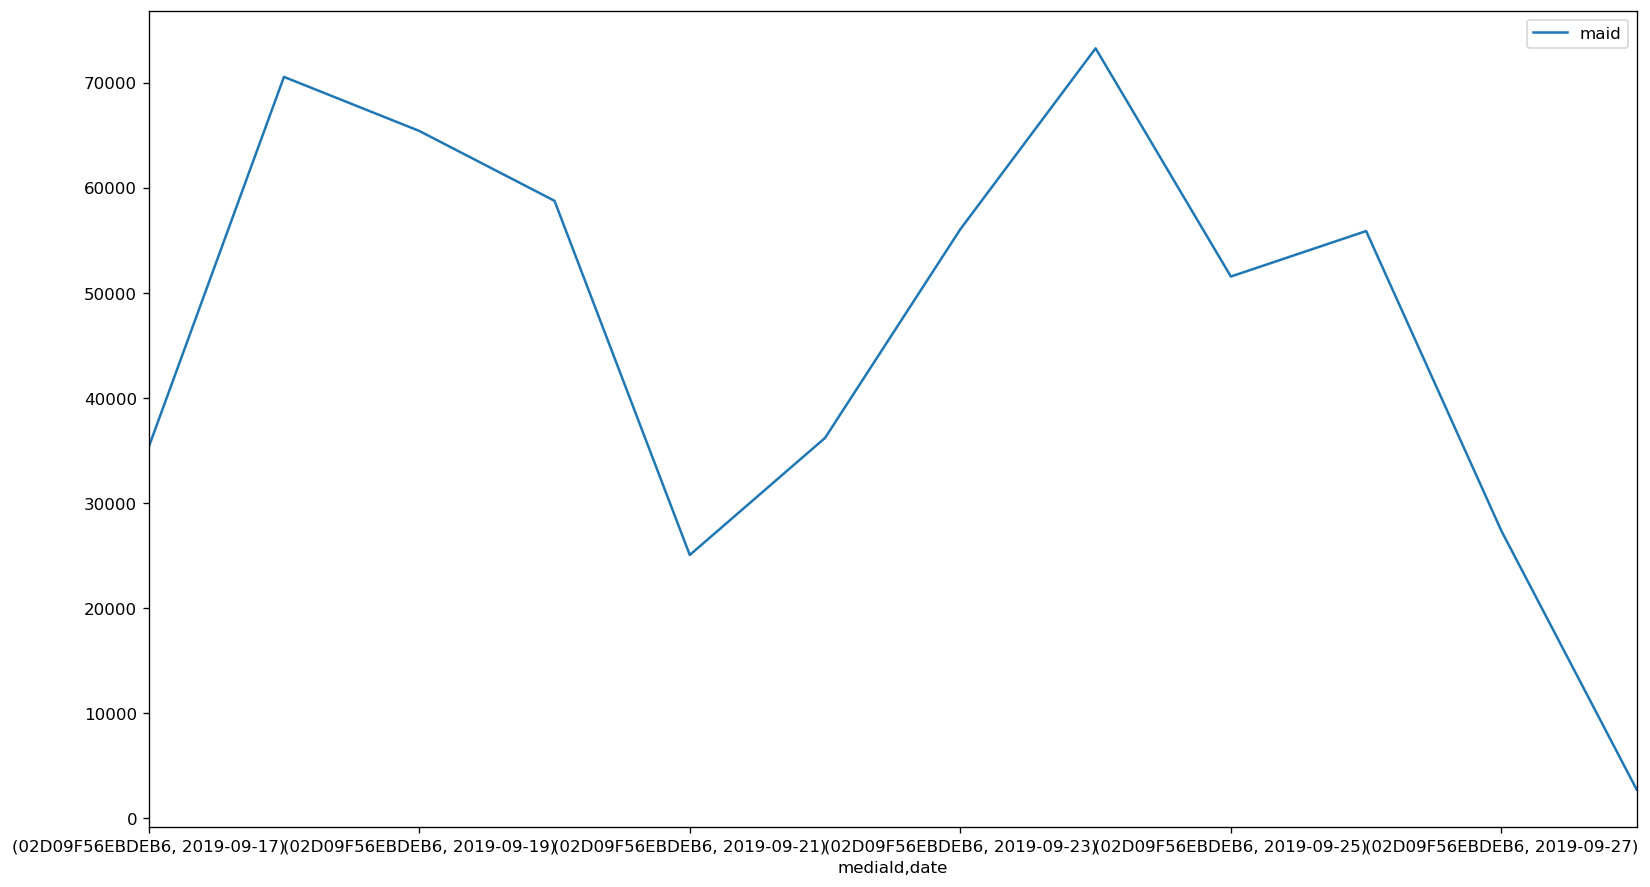

In [150]:
media_vs_day_count_02D0.plot(figsize=(16, 9))

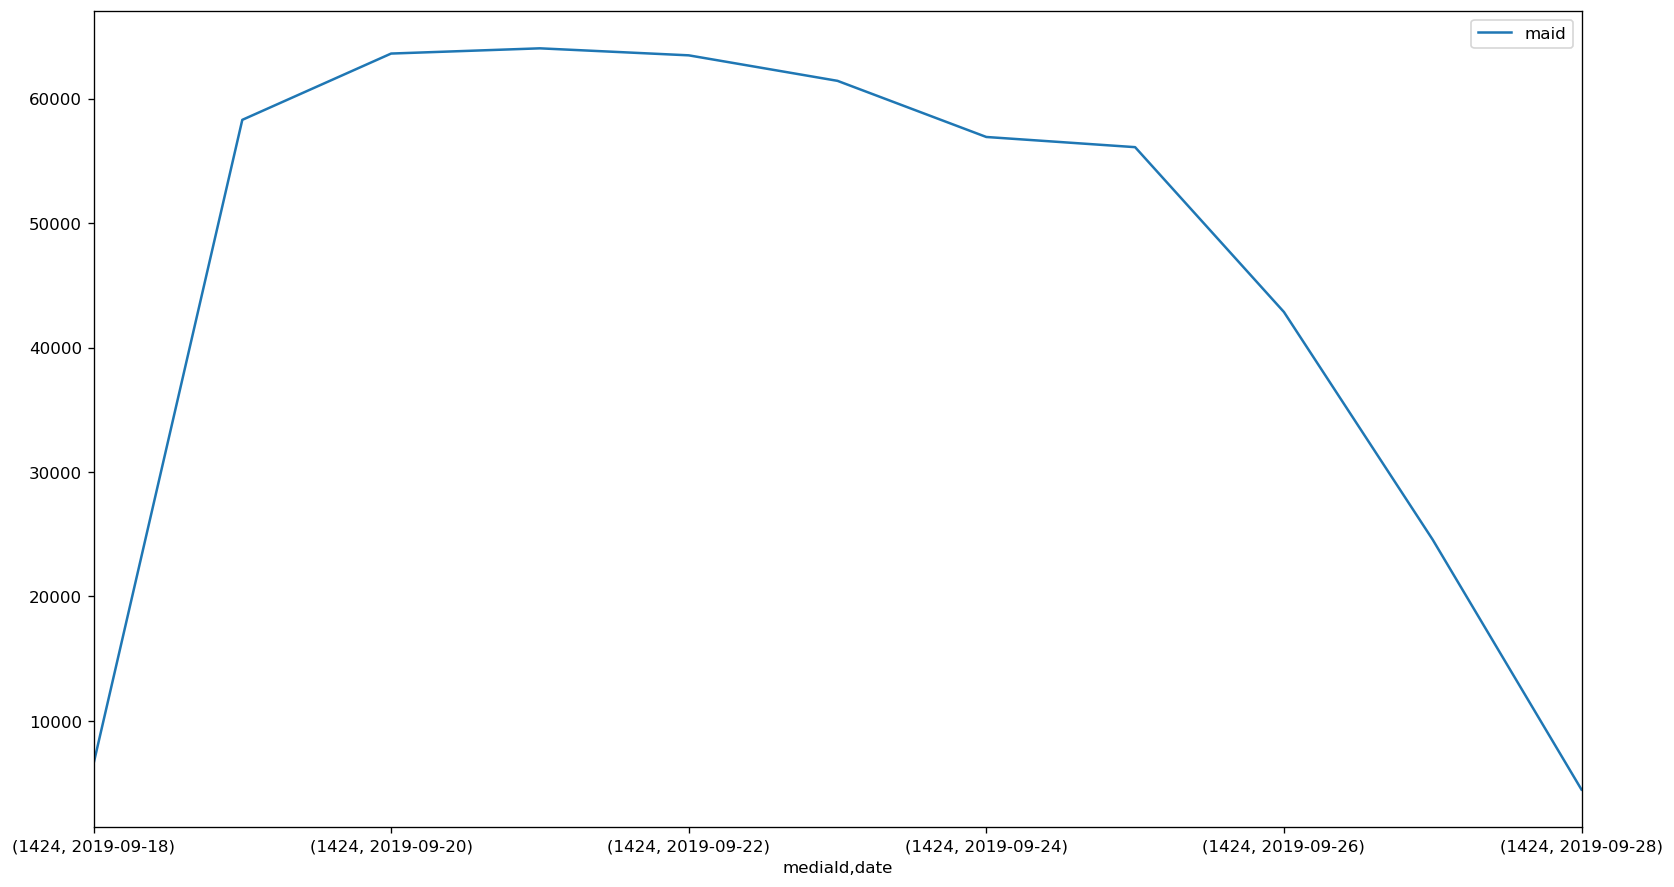

In [151]:
media_vs_day_count_1424.plot(figsize=(16, 9))

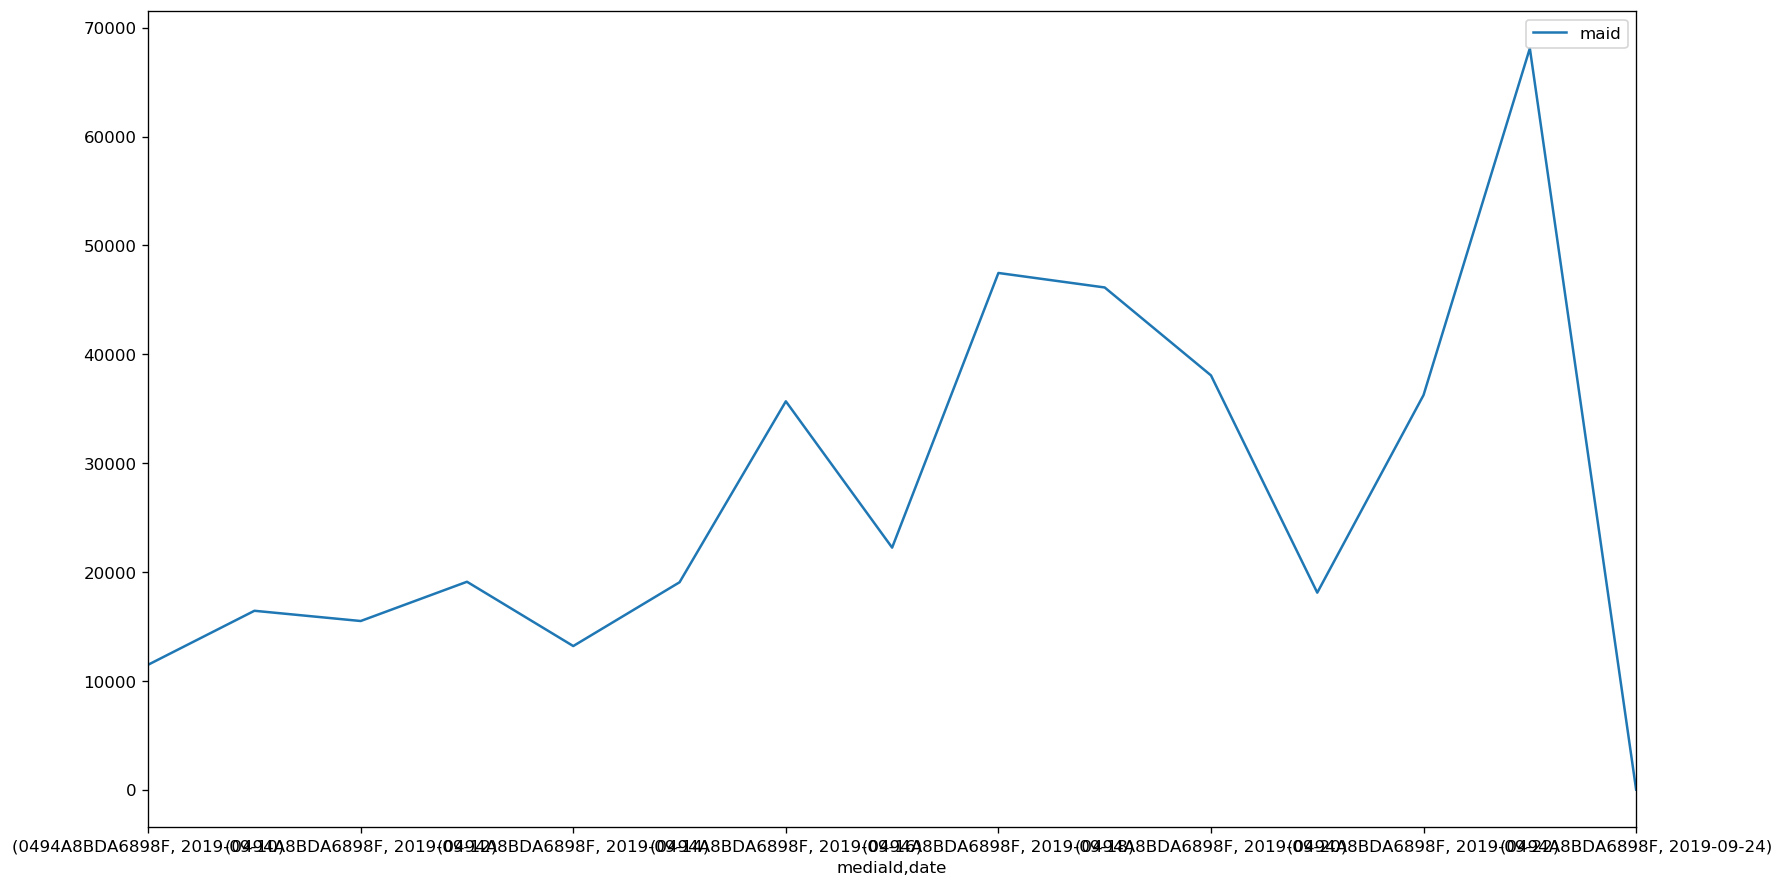

In [152]:
media_vs_day_count_0494.plot(figsize=(16, 9))

In [153]:
media_vs_day_count_02D0.shape

(12, 1)

In [154]:
media_vs_day_count_1424.shape

(11, 1)

In [155]:
media_vs_day_count_0494.shape

(15, 1)

In [156]:
campaign_1424.shape

(502387, 19)

In [157]:
campaign_02D0.shape

(557996, 19)

In [158]:
campaign_0494.shape

(406767, 19)

In [159]:
# #campaign 1424 draw on map
# map_LA_1424 = folium.Map(location=[34.00680,-118.256000],
#                     zoom_start = 13) 

# cam_1424 = campaign_1424.sample(3000)

# heat_data_1424 = [[row['lat'],row['lon']] for index, row in campaign_1424.iterrows()]

# # Plot it on the map
# HeatMap(heat_data_1424).add_to(map_LA_1424)

# # Display the map
# #map_LA_1424
# map_LA_1424.save("heatmap_1424.html")

In [160]:
# map_NY_02D0 = folium.Map(location=[40.71450,-74.002900],
#                     zoom_start = 13)

# campaign_02D0 = campaign_02D0.sample(3000)

# heat_data_ny_02D0 = [[row['lat'],row['lon']] for index, row in campaign_02D0.iterrows()]

# # Plot it on the map
# HeatMap(heat_data_ny_02D0).add_to(map_NY_02D0)

# # Display the map
# #map_NY_02D0
# map_NY_02D0.save("heatmap_02D0.html")

In [161]:
# map_NY_0494 = folium.Map(location=[40.71450,-74.002900],
#                     zoom_start = 13)

# campaign_0494 = campaign_0494.sample(3000)

# heat_data_ny_0494 = [[row['lat'],row['lon']] for index, row in campaign_0494.iterrows()]

# # Plot it on the map
# HeatMap(heat_data_ny_0494).add_to(map_NY_0494)

# # Display the map
# #map_NY_0494
# map_NY_0494.save("heatmap_1424.html")

In [162]:
#Make Coordinate Grids with 0.001 precision, approximately 100 square metres

In [163]:
maids_0and1_unique ['latlon_grid'] = maids_0and1_unique['lat'].map(lambda x: '{:.05g}'.format(x)) + ' || '+ maids_0and1_unique['lon'].map(lambda x: '{:.05g}'.format(x))
maids_0and1_unique ['latlon'] = maids_0and1_unique['lat'].map(str) + ' || '+ maids_0and1_unique['lon'].map(str)

In [164]:
maids_0and1_unique ['latlon_grid'].count()

1467150

In [165]:
maids_0and1_unique ['latlon'].nunique()

917449

In [166]:
maids_0and1_unique ['latlon_grid'].nunique()

29408

In [167]:
#Index(['maid', 'idType', 'timestamp', 'lat', 'lon', 'mediaId', 'datetime',
#       'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second',
#       'weekday', 'bounding_city', 'bounding_city_corr', 'weekofyear'],
#      dtype='object')

In [168]:
maids_0and1_unique['minuteover10']=(maids_0and1_unique ['minute'])/10
maids_0and1_unique['every10minutes']=maids_0and1_unique['minuteover10'].apply(np.floor).astype(int)+1

In [169]:
maids_0and1_unique.head(100)

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,...,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr,latlon_grid,latlon,minuteover10,every10minutes
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02,2019-09-20,07:15:02,2019,...,15,2,4,38,Los Angeles,Los Angeles,33.818 || -118,33.817857000000004 || -118.00263000000001,1.5,2
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,...,52,16,4,38,Los Angeles,Los Angeles,33.804 || -117.94,33.80381 || -117.94153999999999,5.2,6
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,...,52,16,4,38,Los Angeles,Los Angeles,33.804 || -117.94,33.803810999999996 || -117.941547,5.2,6
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31,2019-09-25,23:59:31,2019,...,59,31,2,39,Los Angeles,Los Angeles,33.818 || -118,33.817865000000005 || -118.00263000000001,5.9,6
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22,2019-09-27,02:21:22,2019,...,21,22,4,39,Los Angeles,Los Angeles,33.818 || -118,33.817875 || -118.00266,2.1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,0006ecb6-93a1-49a8-b1b6-f17ab71bf985,idfa,1569198842000,33.876609,-118.171578,1424,2019-09-23 00:34:02,2019-09-23,00:34:02,2019,...,34,2,0,39,Los Angeles,Los Angeles,33.877 || -118.17,33.876609 || -118.171578,3.4,4
98,0006ecb6-93a1-49a8-b1b6-f17ab71bf985,idfa,1569198842000,33.876610,-118.171580,1424,2019-09-23 00:34:02,2019-09-23,00:34:02,2019,...,34,2,0,39,Los Angeles,Los Angeles,33.877 || -118.17,33.87661 || -118.17158,3.4,4
99,00071554-70ce-4cf1-825f-b727c2381114,idfa,1568380860000,40.782787,-73.947495,0494A8BDA6898F,2019-09-13 13:21:00,2019-09-13,13:21:00,2019,...,21,0,4,37,New York,New York,40.783 || -73.947,40.782787 || -73.94749499999999,2.1,3
100,00071554-70ce-4cf1-825f-b727c2381114,idfa,1568380868000,40.782787,-73.947495,0494A8BDA6898F,2019-09-13 13:21:08,2019-09-13,13:21:08,2019,...,21,8,4,37,New York,New York,40.783 || -73.947,40.782787 || -73.94749499999999,2.1,3


In [170]:
maids_0and1_unique.groupby('every10minutes').nunique()['minute']

every10minutes
1    10
2    10
3    10
4    10
5    10
6    10
Name: minute, dtype: int64

In [171]:
#aggregate the maid traffic within a latlon grid for every 10 minutes

In [172]:
maids_in_grid_10min = pd.DataFrame(maids_0and1_unique["maid"].groupby([maids_0and1_unique["date"],maids_0and1_unique["hour"],maids_0and1_unique["every10minutes"],maids_0and1_unique["latlon_grid"]]).count()).reset_index()
maids_in_grid_10min.rename({"maid":"maid_count"},axis=1,inplace=True)
maids_in_grid_10min.sort_values(by=['maid_count'], ascending=False,inplace=True)
maids_in_grid_10min

,date,hour,every10minutes,latlon_grid,maid_count
281433,2019-09-25,15,5,40.715 || -74.003,1502
255321,2019-09-24,15,3,40.715 || -74.003,1486
309135,2019-09-26,15,6,40.715 || -74.003,1463
284546,2019-09-25,16,6,40.715 || -74.003,1441
332494,2019-09-27,16,3,40.715 || -74.003,1398
...,...,...,...,...,...
173405,2019-09-21,22,3,33.782 || -117.97,1
173410,2019-09-21,22,3,33.803 || -117.96,1
173411,2019-09-21,22,3,33.803 || -118.01,1
173412,2019-09-21,22,3,33.807 || -118.15,1


In [173]:
maids_unique_grid_10min = pd.DataFrame(maids_0and1_unique["maid"].groupby([maids_0and1_unique["date"],maids_0and1_unique["hour"],maids_0and1_unique["every10minutes"],maids_0and1_unique["latlon_grid"]]).nunique()).reset_index()
maids_unique_grid_10min.rename({"maid":"maid_unique_count"},axis=1,inplace=True)
maids_unique_grid_10min.sort_values(by=['maid_unique_count'], ascending=False,inplace=True)
maids_unique_grid_10min.head()

,date,hour,every10minutes,latlon_grid,maid_unique_count
284546,2019-09-25,16,6,40.715 || -74.003,722
332494,2019-09-27,16,3,40.715 || -74.003,718
281433,2019-09-25,15,5,40.715 || -74.003,705
255321,2019-09-24,15,3,40.715 || -74.003,655
128893,2019-09-20,13,5,40.715 || -74.003,615


In [174]:
#plot maid traffic for the crowdiest lat-lon pair
llpairmax=maids_unique_grid_10min.loc[(maids_unique_grid_10min['latlon_grid']=='40.715 || -74.003')]
llpairmax.sort_values(by=['date','hour','every10minutes'], ascending=True,inplace=True)
llpairmax.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,date,hour,every10minutes,latlon_grid,maid_unique_count
736,2019-09-10,12,3,40.715 || -74.003,7
1745,2019-09-10,13,5,40.715 || -74.003,12
1893,2019-09-10,13,6,40.715 || -74.003,5
3179,2019-09-10,15,3,40.715 || -74.003,20
3318,2019-09-10,15,4,40.715 || -74.003,8


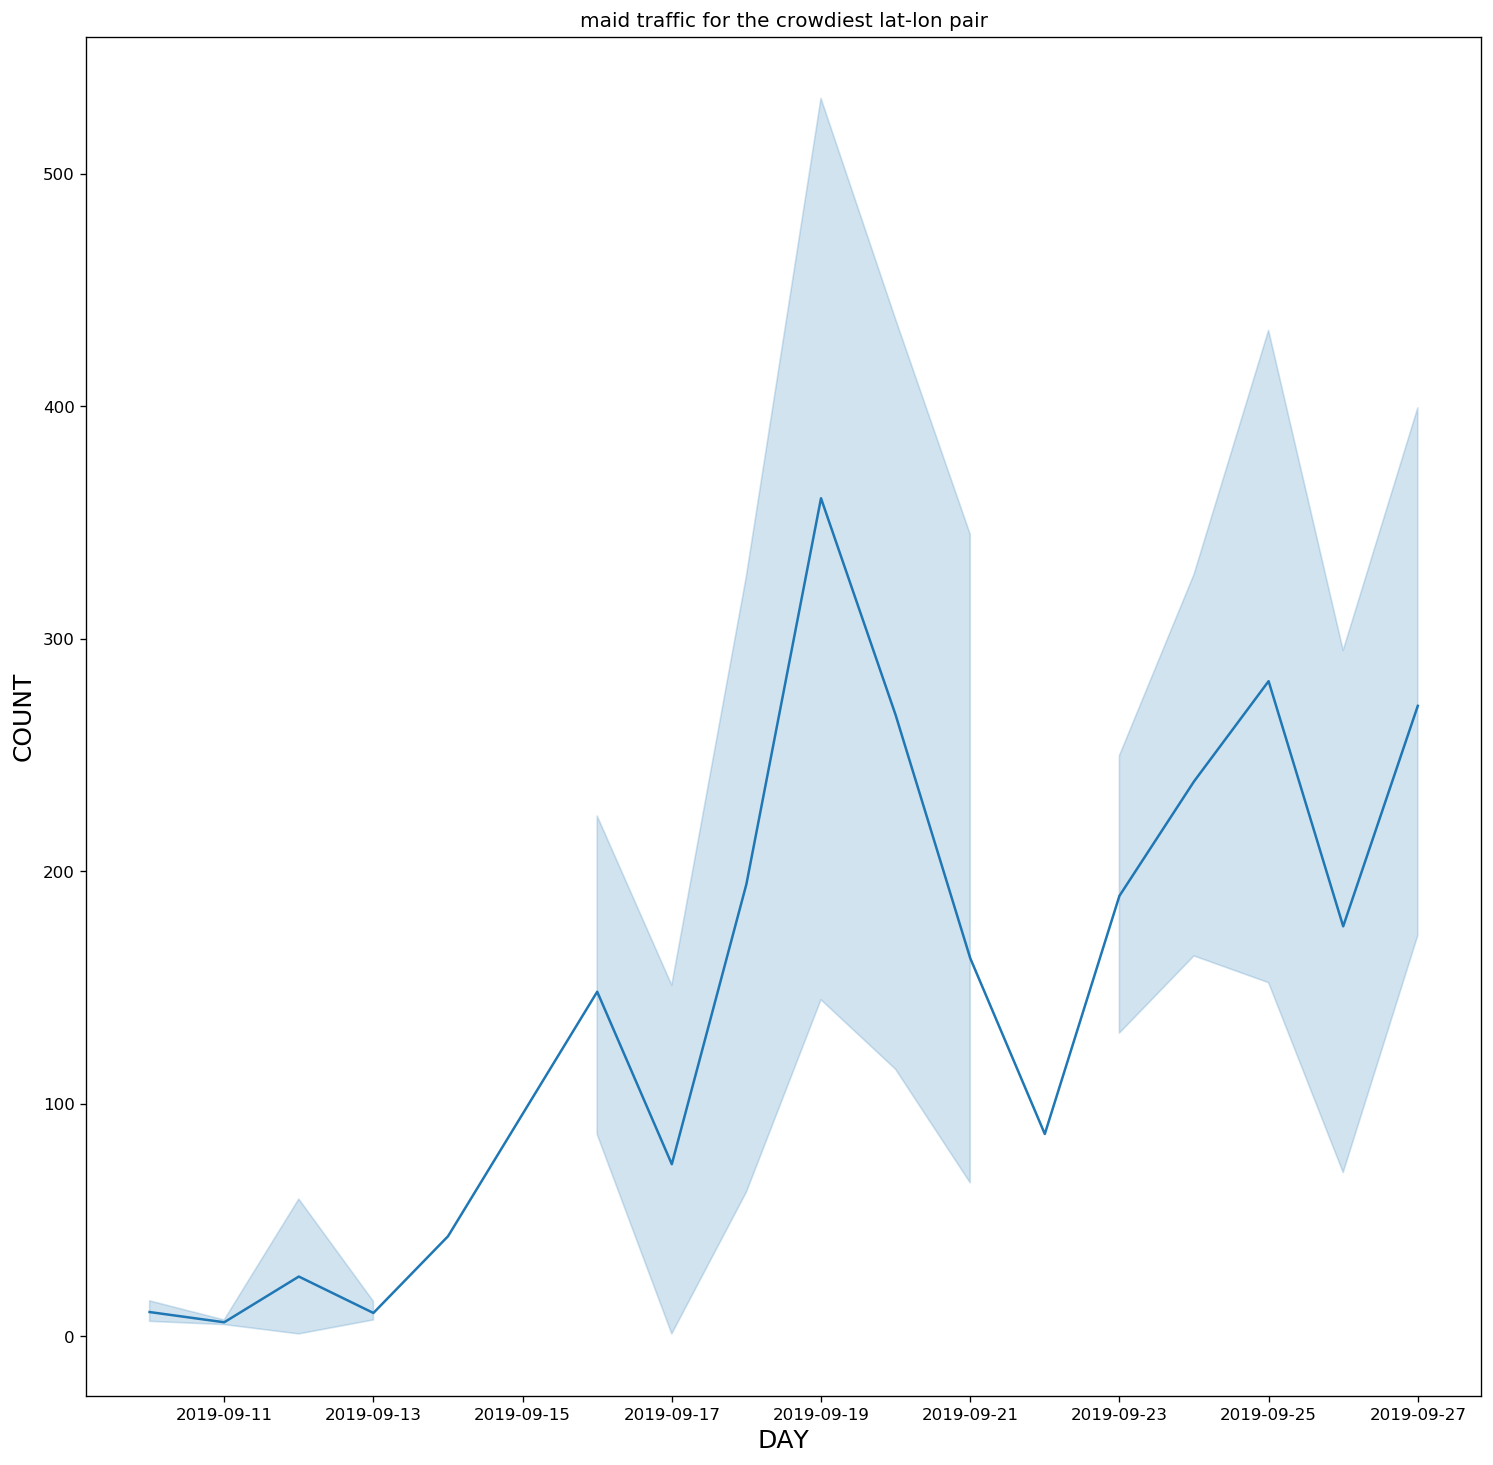

In [175]:
plt.figure(figsize=(15,15))
plt.title("maid traffic for the crowdiest lat-lon pair",fontsize=12)
sns.lineplot(llpairmax.iloc[:,0],llpairmax.iloc[:,4])
plt.xlabel("DAY",fontsize=15)
plt.ylabel("COUNT",fontsize=15);

In [176]:
daily_unique_maids_perday_permediaId = pd.DataFrame(maids_0and1_unique["maid"].groupby([maids_0and1_unique["mediaId"],maids_0and1_unique["date"]]).nunique()).reset_index()
daily_unique_maids_perday_permediaId.rename({"maid":"maid_un_ct"},axis=1,inplace=True)
daily_unique_maids_perday_permediaId.sort_values(by=['mediaId','date'], ascending=True,inplace=True)
daily_unique_maids_perday_permediaId

,mediaId,date,maid_un_ct
0,02D09F56EBDEB6,2019-09-17,8205
1,02D09F56EBDEB6,2019-09-18,13182
2,02D09F56EBDEB6,2019-09-19,12954
3,02D09F56EBDEB6,2019-09-20,12458
4,02D09F56EBDEB6,2019-09-21,5474
5,02D09F56EBDEB6,2019-09-22,6539
6,02D09F56EBDEB6,2019-09-23,11724
7,02D09F56EBDEB6,2019-09-24,15685
8,02D09F56EBDEB6,2019-09-25,11450
9,02D09F56EBDEB6,2019-09-26,10959


In [177]:
weekly_unique_maids_perday_permediaId = pd.DataFrame(maids_0and1_unique["maid"].groupby([maids_0and1_unique["mediaId"],maids_0and1_unique["weekofyear"]]).nunique()).reset_index()
weekly_unique_maids_perday_permediaId.rename({"maid":"maid_un_ct"},axis=1,inplace=True)
weekly_unique_maids_perday_permediaId.sort_values(by=['mediaId','weekofyear'], ascending=True,inplace=True)
weekly_unique_maids_perday_permediaId

,mediaId,weekofyear,maid_un_ct
0,02D09F56EBDEB6,38,45892
1,02D09F56EBDEB6,39,46752
2,0494A8BDA6898F,37,34146
3,0494A8BDA6898F,38,61368
4,0494A8BDA6898F,39,16737
5,1424,38,66807
6,1424,39,69474


In [178]:
maids_0and1_unique.dtypes

maid                          object
idType                        object
timestamp                      int64
lat                          float64
lon                          float64
mediaId                       object
datetime              datetime64[ns]
date                          object
time                          object
year                           int64
month                          int64
day                            int64
hour                           int64
minute                         int64
second                         int64
weekday                        int64
weekofyear                    object
bounding_city                 object
bounding_city_corr            object
latlon_grid                   object
latlon                        object
minuteover10                 float64
every10minutes                 int32
dtype: object

In [179]:
mediaId_unique_grid_10min = pd.DataFrame(maids_0and1_unique["maid"].groupby([maids_0and1_unique['year'],maids_0and1_unique['month'],maids_0and1_unique['day'],maids_0and1_unique['bounding_city_corr'],maids_0and1_unique['weekday'],maids_0and1_unique["date"],maids_0and1_unique["hour"],maids_0and1_unique["every10minutes"],maids_0and1_unique["latlon_grid"]]).nunique()).reset_index()
mediaId_unique_grid_10min.rename({"maid":"maid_unique_count"},axis=1,inplace=True)
mediaId_unique_grid_10min.sort_values(by=['year','month','day','date','hour','every10minutes'], ascending=True,inplace=True)
mediaId_unique_grid_10min.head()

,year,month,day,bounding_city_corr,weekday,date,hour,every10minutes,latlon_grid,maid_unique_count
0,2019,9,10,New York,1,2019-09-10,11,1,40.618 || -73.964,1
1,2019,9,10,New York,1,2019-09-10,11,1,40.657 || -73.793,1
2,2019,9,10,New York,1,2019-09-10,11,1,40.719 || -74.007,1
3,2019,9,10,New York,1,2019-09-10,11,1,40.74 || -73.985,2
4,2019,9,10,New York,1,2019-09-10,11,1,40.74 || -73.986,1


In [180]:
#mediaId_unique_grid_10min['lat_grid']=mediaId_unique_grid_10min['latlon_grid'].str.split(" || ", n = 1, expand = True)[0]
#mediaId_unique_grid_10min['lon_grid']=mediaId_unique_grid_10min['latlon_grid'].str.split(" || ", n = 1, expand = True)[1]
#pd.DataFrame(mediaId_unique_grid_10min.latlon_grid.str.split(' || ',1).tolist(), columns = ['lat_grid','lon_grid'])
mediaId_unique_grid_10min[['lat_grid','lon_grid']] = mediaId_unique_grid_10min.latlon_grid.apply( lambda x: pd.Series(str(x).split(" || "))) 
mediaId_unique_grid_10min.head()

,year,month,day,bounding_city_corr,weekday,date,hour,every10minutes,latlon_grid,maid_unique_count,lat_grid,lon_grid
0,2019,9,10,New York,1,2019-09-10,11,1,40.618 || -73.964,1,40.618,-73.964
1,2019,9,10,New York,1,2019-09-10,11,1,40.657 || -73.793,1,40.657,-73.793
2,2019,9,10,New York,1,2019-09-10,11,1,40.719 || -74.007,1,40.719,-74.007
3,2019,9,10,New York,1,2019-09-10,11,1,40.74 || -73.985,2,40.74,-73.985
4,2019,9,10,New York,1,2019-09-10,11,1,40.74 || -73.986,1,40.74,-73.986


In [181]:
labelencoder = LabelEncoder()
mediaId_unique_grid_10min['bounding_city_label'] = labelencoder.fit_transform(mediaId_unique_grid_10min['bounding_city_corr'])

In [182]:
print(mediaId_unique_grid_10min['maid_unique_count'].min())
print(mediaId_unique_grid_10min['maid_unique_count'].max())
print(mediaId_unique_grid_10min['maid_unique_count'].median())

1
722
1.0


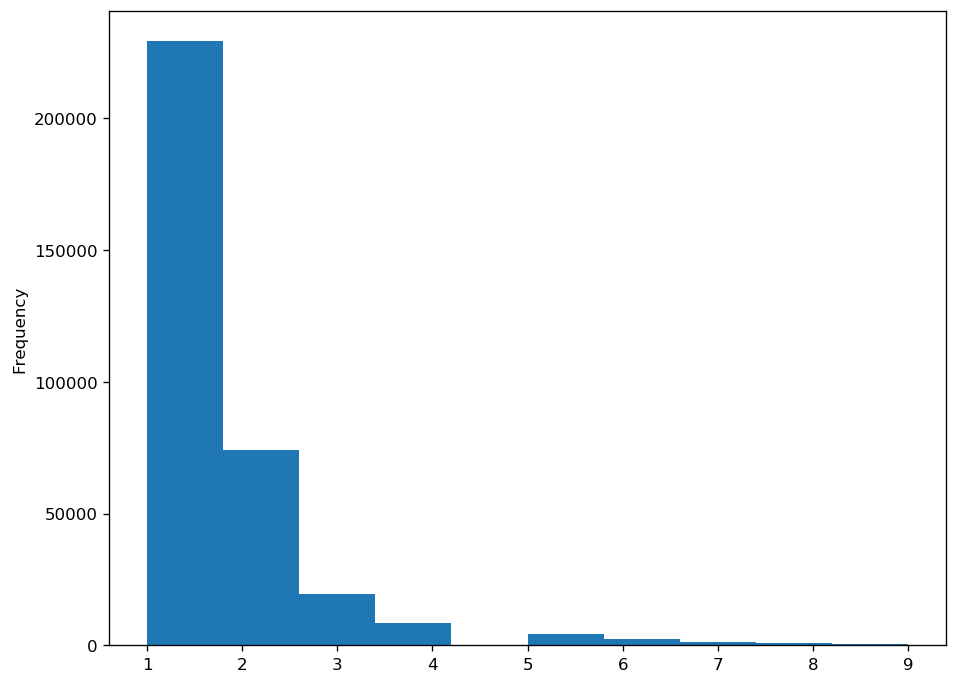

In [183]:
mediaId_unique_grid_10min['maid_unique_count'].loc[(mediaId_unique_grid_10min['maid_unique_count']<10)].plot(kind='hist')
plt.show()

In [184]:
mediaId_unique_grid_10min['minute']=(mediaId_unique_grid_10min['every10minutes']-1)*10
mediaId_unique_grid_10min.dtypes

year                    int64
month                   int64
day                     int64
bounding_city_corr     object
weekday                 int64
date                   object
hour                    int64
every10minutes          int64
latlon_grid            object
maid_unique_count       int64
lat_grid               object
lon_grid               object
bounding_city_label     int32
minute                  int64
dtype: object

In [185]:
mediaId_unique_grid_10min['dattim']=pd.to_datetime(mediaId_unique_grid_10min[['year','month','day','hour','minute']])
mediaId_unique_grid_10min.dtypes

year                            int64
month                           int64
day                             int64
bounding_city_corr             object
weekday                         int64
date                           object
hour                            int64
every10minutes                  int64
latlon_grid                    object
maid_unique_count               int64
lat_grid                       object
lon_grid                       object
bounding_city_label             int32
minute                          int64
dattim                 datetime64[ns]
dtype: object

In [186]:
test_grid10min=mediaId_unique_grid_10min.loc[(mediaId_unique_grid_10min['date']==datetime.strptime("2019-09-23", "%Y-%m-%d").date())]
train_grid10min=mediaId_unique_grid_10min.loc[(mediaId_unique_grid_10min['date']<datetime.strptime("2019-09-23", "%Y-%m-%d").date())]

In [187]:
test_targetground_truth=test_grid10min['maid_unique_count']
test_grid10min.drop(['maid_unique_count'],axis=1,inplace=True)
test_grid10min.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,year,month,day,bounding_city_corr,weekday,date,hour,every10minutes,latlon_grid,lat_grid,lon_grid,bounding_city_label,minute,dattim
204517,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.803 || -117.99,33.803,-117.99,0,0,2019-09-23
204518,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.804 || -117.99,33.804,-117.99,0,0,2019-09-23
204519,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.818 || -117.98,33.818,-117.98,0,0,2019-09-23
204520,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.831 || -118.08,33.831,-118.08,0,0,2019-09-23
204521,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.832 || -118.08,33.832,-118.08,0,0,2019-09-23


#### Model Trial 1: ARIMA 

##### Campaign 1424

In [188]:
campaign_1424.columns

Index(['maid', 'idType', 'timestamp', 'lat', 'lon', 'mediaId', 'datetime',
       'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'weekday', 'weekofyear', 'bounding_city', 'bounding_city_corr'],
      dtype='object')

In [189]:
campaign_1424['minuteover10']=(campaign_1424 ['minute'])/10
campaign_1424['every10minutes']=campaign_1424['minuteover10'].apply(np.floor).astype(int)+1

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [190]:
#the arima model could be used by using each campaigns exposed maids as a time series

#a frequency of 10 minutes will be designed so that arima model works with the index
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta

dtfreq_sec = pd.Series()

i=0
for result in perdelta(
    datetime.strptime('2019-09-18 21:20', '%Y-%m-%d %H:%M'),
    datetime.strptime('2019-09-28 22:50', '%Y-%m-%d %H:%M'),
    timedelta(minutes=10)):
    
    dtfreq_sec = dtfreq_sec.set_value(i,result)
    i=i+1




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [191]:
dtfreq_sec_frame=dtfreq_sec.to_frame()
dtfreq_sec_frame.rename(columns={0:'dattim'},inplace=True)

In [192]:
dtfreq_sec_frame

,dattim
0,2019-09-18 21:20:00
1,2019-09-18 21:30:00
2,2019-09-18 21:40:00
3,2019-09-18 21:50:00
4,2019-09-18 22:00:00
...,...
1444,2019-09-28 22:00:00
1445,2019-09-28 22:10:00
1446,2019-09-28 22:20:00
1447,2019-09-28 22:30:00


In [193]:
campaign_1424_ts = pd.DataFrame(campaign_1424["maid"].groupby([campaign_1424['date'], campaign_1424['year'], campaign_1424['month'],
    campaign_1424['day'], campaign_1424['hour'], campaign_1424['every10minutes']]).nunique()).reset_index()
campaign_1424_ts['minute']=(campaign_1424_ts['every10minutes']-1)*10#minute for 10 min intervals
campaign_1424_ts['dattim']=pd.to_datetime(campaign_1424_ts[['year','month','day','hour','minute']])
campaign_1424_ts.sort_values(by=['dattim'], ascending=True,inplace=True)
campaign_1424_ts.head()

,date,year,month,day,hour,every10minutes,maid,minute,dattim
0,2019-09-18,2019,9,18,21,3,9,20,2019-09-18 21:20:00
1,2019-09-18,2019,9,18,21,4,56,30,2019-09-18 21:30:00
2,2019-09-18,2019,9,18,21,5,62,40,2019-09-18 21:40:00
3,2019-09-18,2019,9,18,21,6,134,50,2019-09-18 21:50:00
4,2019-09-18,2019,9,18,22,1,222,0,2019-09-18 22:00:00


In [194]:
campaign_1424_ts_data = pd.merge(dtfreq_sec_frame,
                 campaign_1424_ts[['dattim','maid']],
                 on='dattim', 
                 how='left')
campaign_1424_ts_data.sort_values(by=['dattim'], ascending=True,inplace=True)
campaign_1424_ts_data.head(100)

,dattim,maid
0,2019-09-18 21:20:00,9.0
1,2019-09-18 21:30:00,56.0
2,2019-09-18 21:40:00,62.0
3,2019-09-18 21:50:00,134.0
4,2019-09-18 22:00:00,222.0
...,...,...
95,2019-09-19 13:10:00,86.0
96,2019-09-19 13:20:00,68.0
97,2019-09-19 13:30:00,65.0
98,2019-09-19 13:40:00,63.0


In [195]:
campaign_1424_ts_data.isna().sum()

dattim    0
maid      7
dtype: int64

In [196]:
campaign_1424_ts_data.fillna(0,inplace=True)

In [197]:
campaign_1424_ts_data.dtypes

dattim    datetime64[ns]
maid             float64
dtype: object

In [198]:
campaign_1424_ts_test=campaign_1424_ts_data[(campaign_1424_ts_data['dattim'] > '2019-09-22 23:59:59') & (campaign_1424_ts_data['dattim'] < '2019-09-24 00:00:00')]

In [199]:
campaign_1424_ts_test

,dattim,maid
592,2019-09-23 00:00:00,172.0
593,2019-09-23 00:10:00,130.0
594,2019-09-23 00:20:00,158.0
595,2019-09-23 00:30:00,128.0
596,2019-09-23 00:40:00,144.0
...,...,...
731,2019-09-23 23:10:00,283.0
732,2019-09-23 23:20:00,333.0
733,2019-09-23 23:30:00,283.0
734,2019-09-23 23:40:00,315.0


In [200]:
campaign_1424_ts_train=campaign_1424_ts_data[(campaign_1424_ts_data['dattim'] < '2019-09-23 00:00:00')]

In [201]:
campaign_1424_ts_test.set_index('dattim', inplace=True)
campaign_1424_ts_test.head()

,maid
dattim,
2019-09-23 00:00:00,172.0
2019-09-23 00:10:00,130.0
2019-09-23 00:20:00,158.0
2019-09-23 00:30:00,128.0
2019-09-23 00:40:00,144.0


In [202]:
campaign_1424_ts_train.set_index('dattim', inplace=True)

In [203]:
# campaign_1424_ts_train.index = pd.DatetimeIndex(campaign_1424_ts_train.index.values,freq=campaign_1424_ts_train.index.inferred_freq)
# campaign_1424_ts_train.head()

In [204]:
campaign_1424_ts_train.isna().sum()

maid    0
dtype: int64

In [205]:
model_arima_1424=ARIMA(campaign_1424_ts_train,order=(2,0,3),freq=campaign_1424_ts_train.index.inferred_freq)
model_arima_1424=model_arima_1424.fit()
model_arima_1424.fittedvalues

dattim
2019-09-18 21:20:00    160.392926
2019-09-18 21:30:00     32.877824
2019-09-18 21:40:00     48.658141
2019-09-18 21:50:00     59.235429
2019-09-18 22:00:00     90.272971
                          ...    
2019-09-22 23:10:00    156.897418
2019-09-22 23:20:00    188.037087
2019-09-22 23:30:00    167.272765
2019-09-22 23:40:00    155.289219
2019-09-22 23:50:00    160.497935
Length: 592, dtype: float64

In [206]:
# Actual vs Fitted
predict_1424_arima = model_arima_1424.predict(end='2019-09-23 23:50:00',dynamic=False)

In [207]:
predict_1424_arima.tail(10)

2019-09-23 22:20:00    160.753833
2019-09-23 22:30:00    160.746283
2019-09-23 22:40:00    160.738887
2019-09-23 22:50:00    160.731649
2019-09-23 23:00:00    160.724560
2019-09-23 23:10:00    160.717621
2019-09-23 23:20:00    160.710826
2019-09-23 23:30:00    160.704175
2019-09-23 23:40:00    160.697661
2019-09-23 23:50:00    160.691285
Freq: 10T, dtype: float64

In [503]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mape(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def med_ape(y_true, y_pred): 
    return np.median(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100


# def mape(y_true, y_predictions):
#     return np.mean((np.abs(y_true-y_predictions))/y_true)*100
# def med_ape(y_true, y_predictions):
#     return np.median((np.abs(y_true-y_predictions))/y_true)*100

In [209]:
y_predictions=predict_1424_arima.loc[(predict_1424_arima.index >= '2019-09-23 00:00:00')].to_frame().rename(columns={0:'maid'})
y_predictions.head()

,maid
2019-09-23 00:00:00,164.042701
2019-09-23 00:10:00,170.564567
2019-09-23 00:20:00,162.565649
2019-09-23 00:30:00,169.465370
2019-09-23 00:40:00,163.080410


In [210]:
y_predictions.tail()

,maid
2019-09-23 23:10:00,160.717621
2019-09-23 23:20:00,160.710826
2019-09-23 23:30:00,160.704175
2019-09-23 23:40:00,160.697661
2019-09-23 23:50:00,160.691285


In [211]:
campaign_1424_ts_test.head()

,maid
dattim,
2019-09-23 00:00:00,172.0
2019-09-23 00:10:00,130.0
2019-09-23 00:20:00,158.0
2019-09-23 00:30:00,128.0
2019-09-23 00:40:00,144.0


In [212]:
campaign_1424_ts_test.tail()

,maid
dattim,
2019-09-23 23:10:00,283.0
2019-09-23 23:20:00,333.0
2019-09-23 23:30:00,283.0
2019-09-23 23:40:00,315.0
2019-09-23 23:50:00,255.0


In [213]:
campaign_1424_ts_test.head()

,maid
dattim,
2019-09-23 00:00:00,172.0
2019-09-23 00:10:00,130.0
2019-09-23 00:20:00,158.0
2019-09-23 00:30:00,128.0
2019-09-23 00:40:00,144.0


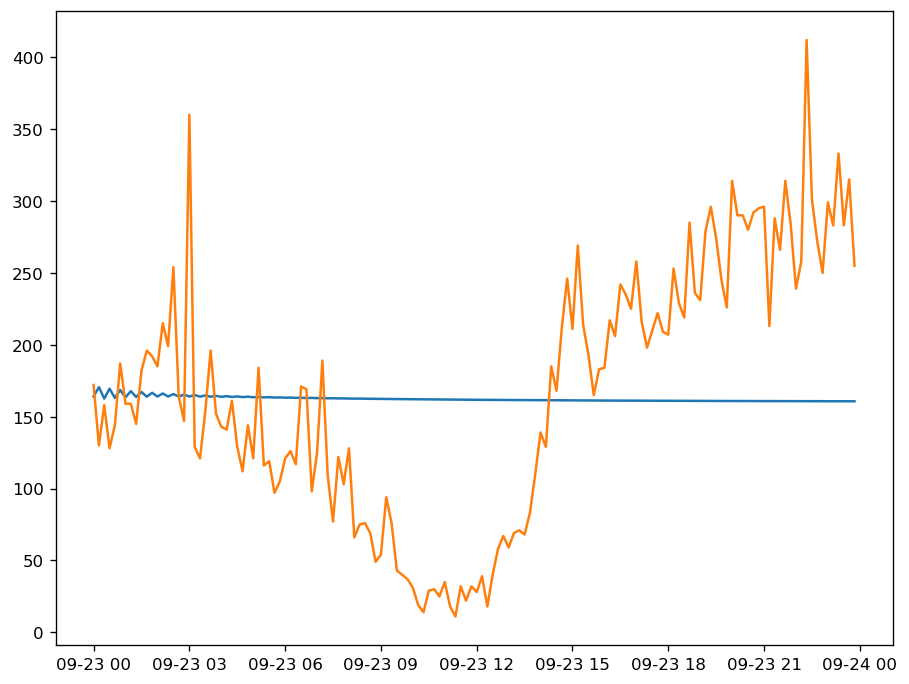

In [214]:
matplotlib.pyplot.plot(y_predictions.index, y_predictions.maid)
matplotlib.pyplot.plot(campaign_1424_ts_test.index, campaign_1424_ts_test.maid)
matplotlib.pyplot.show()

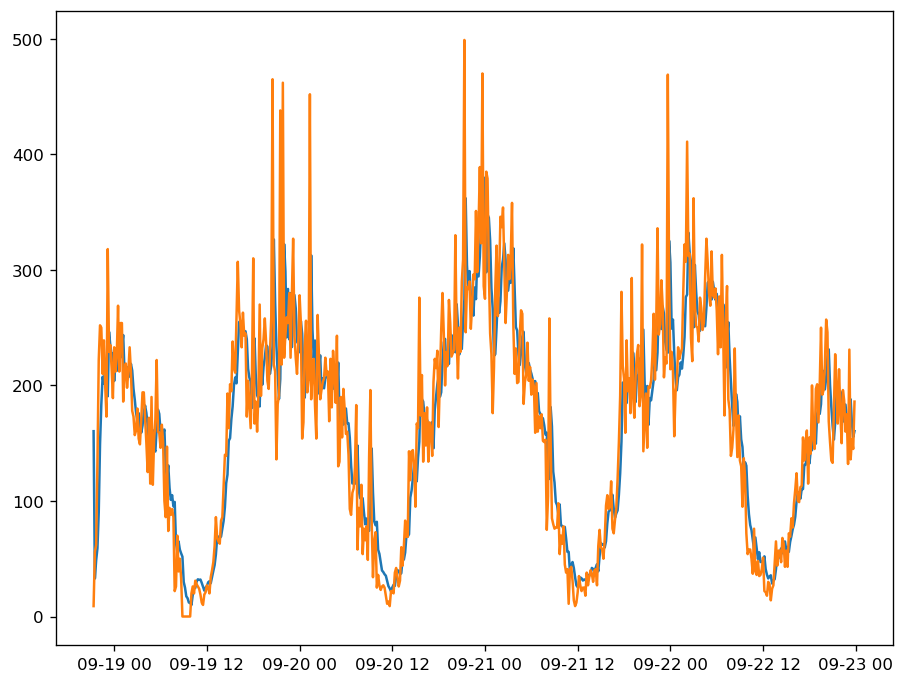

In [215]:
#plot train predictions
y_train=predict_1424_arima.loc[(predict_1424_arima.index < '2019-09-23 00:00:00')].to_frame().rename(columns={0:'maid'})
matplotlib.pyplot.plot(y_train.index, y_train.maid)
matplotlib.pyplot.plot(campaign_1424_ts_train.index, campaign_1424_ts_train.maid)
matplotlib.pyplot.show()

In [504]:
print(mape(campaign_1424_ts_test,y_predictions))

110.48363627690567


In [505]:
print(med_ape(campaign_1424_ts_test,y_predictions))

37.212602449065436


So the ARIMA model pretty much stuck to the mean and did not catch the fluctuations in real data for test.

### Model 2: Prophet 

In [218]:
campaign_1424_ts_train_prophet=campaign_1424_ts_train
campaign_1424_ts_train_prophet["dts"] = campaign_1424_ts_train_prophet.index
campaign_1424_ts_train_prophet["ds"] = campaign_1424_ts_train_prophet["dts"].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [219]:
campaign_1424_ts_train_prophet.drop(['dts'],axis=1,inplace=True)
campaign_1424_ts_train_prophet.rename(columns={'maid':'y'},inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [220]:
campaign_1424_ts_train_prophet.head()

,y,ds
dattim,,
2019-09-18 21:20:00,9.0,2019-09-18 21:20:00
2019-09-18 21:30:00,56.0,2019-09-18 21:30:00
2019-09-18 21:40:00,62.0,2019-09-18 21:40:00
2019-09-18 21:50:00,134.0,2019-09-18 21:50:00
2019-09-18 22:00:00,222.0,2019-09-18 22:00:00


In [221]:
model=Prophet(interval_width=0.85,daily_seasonality=True)
model=model.fit(campaign_1424_ts_train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [222]:
campaign_1424_ts_test_prophet=campaign_1424_ts_test
campaign_1424_ts_test_prophet["dts"] = campaign_1424_ts_test_prophet.index
campaign_1424_ts_test_prophet["ds"] = campaign_1424_ts_test_prophet["dts"].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
campaign_1424_ts_test_prophet.drop(['dts'],axis=1,inplace=True)
campaign_1424_ts_test_prophet.drop(['maid'],axis=1,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [223]:
campaign_1424_ts_test_prophet.head()

,ds
dattim,
2019-09-23 00:00:00,2019-09-23 00:00:00
2019-09-23 00:10:00,2019-09-23 00:10:00
2019-09-23 00:20:00,2019-09-23 00:20:00
2019-09-23 00:30:00,2019-09-23 00:30:00
2019-09-23 00:40:00,2019-09-23 00:40:00


In [224]:
forecast_campaign_1424_ts_test_prophet=model.predict(campaign_1424_ts_test_prophet)

In [225]:
forecast_campaign_1424_ts_test_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-09-23 00:00:00,132.698710,142.008288,303.684870,132.698710,132.698710,89.436371,89.436371,89.436371,89.436371,89.436371,89.436371,0.0,0.0,0.0,222.135081
1,2019-09-23 00:10:00,132.371132,146.224613,303.083661,132.371132,132.371132,89.403153,89.403153,89.403153,89.403153,89.403153,89.403153,0.0,0.0,0.0,221.774285
2,2019-09-23 00:20:00,132.043554,145.651912,296.833438,132.043554,132.043554,89.232261,89.232261,89.232261,89.232261,89.232261,89.232261,0.0,0.0,0.0,221.275815
3,2019-09-23 00:30:00,131.715976,145.197309,296.651137,131.715976,131.715976,88.931154,88.931154,88.931154,88.931154,88.931154,88.931154,0.0,0.0,0.0,220.647129
4,2019-09-23 00:40:00,131.388397,142.468350,307.076066,131.382342,131.394999,88.507938,88.507938,88.507938,88.507938,88.507938,88.507938,0.0,0.0,0.0,219.896335


In [226]:
#forecast_campaign_1424_ts_test_prophet.set_index('ds', inplace=True)
#forecast_campaign_1424_ts_test_prophet.head()

In [227]:
campaign_1424_ts_test.head()

,ds
dattim,
2019-09-23 00:00:00,2019-09-23 00:00:00
2019-09-23 00:10:00,2019-09-23 00:10:00
2019-09-23 00:20:00,2019-09-23 00:20:00
2019-09-23 00:30:00,2019-09-23 00:30:00
2019-09-23 00:40:00,2019-09-23 00:40:00


In [228]:
campaign_1424_ts_test=campaign_1424_ts_data[(campaign_1424_ts_data['dattim'] > '2019-09-22 23:59:59') & (campaign_1424_ts_data['dattim'] < '2019-09-24 00:00:00')]
campaign_1424_ts_test.set_index('dattim', inplace=True)
campaign_1424_ts_test.head()

,maid
dattim,
2019-09-23 00:00:00,172.0
2019-09-23 00:10:00,130.0
2019-09-23 00:20:00,158.0
2019-09-23 00:30:00,128.0
2019-09-23 00:40:00,144.0


In [229]:
yhat_forecast_campaign_1424_prophet=forecast_campaign_1424_ts_test_prophet[['ds','yhat']]
yhat_forecast_campaign_1424_prophet.set_index('ds', inplace=True)
yhat_forecast_campaign_1424_prophet.head()

,yhat
ds,
2019-09-23 00:00:00,222.135081
2019-09-23 00:10:00,221.774285
2019-09-23 00:20:00,221.275815
2019-09-23 00:30:00,220.647129
2019-09-23 00:40:00,219.896335


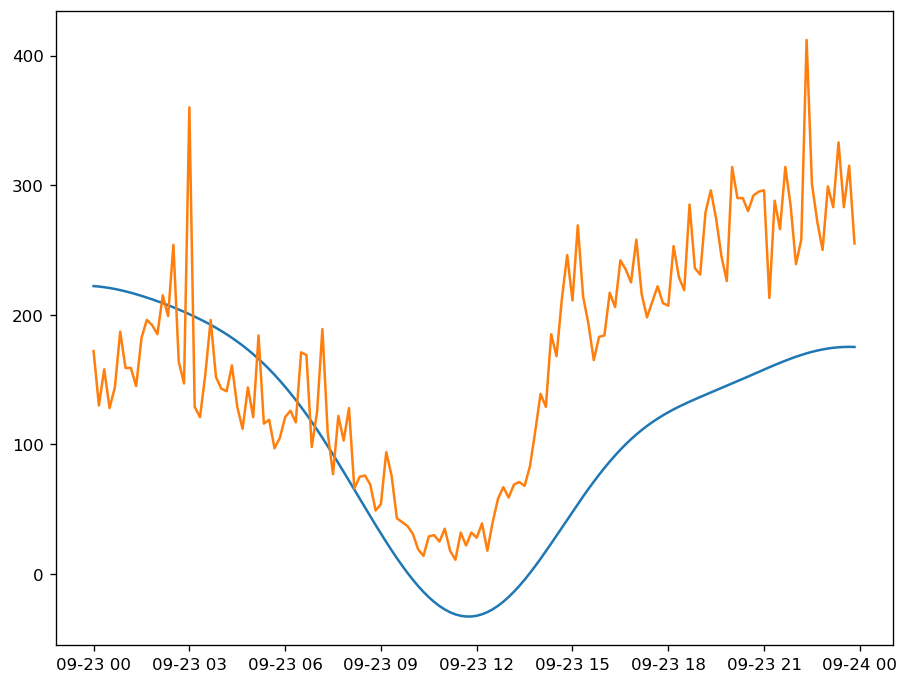

In [230]:
matplotlib.pyplot.plot(yhat_forecast_campaign_1424_prophet.index, yhat_forecast_campaign_1424_prophet.yhat)
matplotlib.pyplot.plot(campaign_1424_ts_test.index, campaign_1424_ts_test.maid)
matplotlib.pyplot.show()

In [506]:
print(mape(campaign_1424_ts_test.maid,yhat_forecast_campaign_1424_prophet.yhat))
print(med_ape(campaign_1424_ts_test.maid,yhat_forecast_campaign_1424_prophet.yhat))

64.98713801278674
45.79894032171411


### Use Xgboost for predicting with features 

Think of the number of unique maids per lat-lon grid and 10 minute intervals as target,
try to predict for the next days

In [232]:
test_grid10min.head()

,year,month,day,bounding_city_corr,weekday,date,hour,every10minutes,latlon_grid,lat_grid,lon_grid,bounding_city_label,minute,dattim
204517,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.803 || -117.99,33.803,-117.99,0,0,2019-09-23
204518,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.804 || -117.99,33.804,-117.99,0,0,2019-09-23
204519,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.818 || -117.98,33.818,-117.98,0,0,2019-09-23
204520,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.831 || -118.08,33.831,-118.08,0,0,2019-09-23
204521,2019,9,23,Los Angeles,0,2019-09-23,0,1,33.832 || -118.08,33.832,-118.08,0,0,2019-09-23


In [233]:
train_grid10min.head()

,year,month,day,bounding_city_corr,weekday,date,hour,every10minutes,latlon_grid,maid_unique_count,lat_grid,lon_grid,bounding_city_label,minute,dattim
0,2019,9,10,New York,1,2019-09-10,11,1,40.618 || -73.964,1,40.618,-73.964,1,0,2019-09-10 11:00:00
1,2019,9,10,New York,1,2019-09-10,11,1,40.657 || -73.793,1,40.657,-73.793,1,0,2019-09-10 11:00:00
2,2019,9,10,New York,1,2019-09-10,11,1,40.719 || -74.007,1,40.719,-74.007,1,0,2019-09-10 11:00:00
3,2019,9,10,New York,1,2019-09-10,11,1,40.74 || -73.985,2,40.74,-73.985,1,0,2019-09-10 11:00:00
4,2019,9,10,New York,1,2019-09-10,11,1,40.74 || -73.986,1,40.74,-73.986,1,0,2019-09-10 11:00:00


In [234]:
#the predictions must be done for all available lat-lon grids within the train data (where the campaigns are active before 23 Sept 2019)

campaign_locations=train_grid10min.latlon_grid.unique()

In [235]:
campaign_locations

array(['40.618 || -73.964', '40.657 || -73.793', '40.719 || -74.007', ...,
       '34.025 || -118.45', '34.116 || -118.17', '34.143 || -118.25'],
      dtype=object)

In [236]:
len(campaign_locations)

22631

In [237]:
camp_locs= pd.DataFrame(data=campaign_locations).rename(columns={0:'latlon_grid'})

In [238]:
camp_locs.head()

,latlon_grid
0,40.618 || -73.964
1,40.657 || -73.793
2,40.719 || -74.007
3,40.74 || -73.985
4,40.74 || -73.986


In [239]:
camp_locs.shape

(22631, 1)

In [240]:
#this is all the date time entries for test
test_dattims = dtfreq_sec_frame.loc[(dtfreq_sec_frame['dattim'] > '2019-09-22 23:59:59') & (dtfreq_sec_frame['dattim'] < '2019-09-24 00:00:00')]
test_dattims.reset_index(inplace=True)
test_dattims.drop(['index'],axis=1,inplace=True)
test_dattims.head()

,dattim
0,2019-09-23 00:00:00
1,2019-09-23 00:10:00
2,2019-09-23 00:20:00
3,2019-09-23 00:30:00
4,2019-09-23 00:40:00


In [241]:
test_dattims.shape

(144, 1)

In [242]:
lc = camp_locs['latlon_grid'].tolist()
dt = test_dattims['dattim'].tolist()

indext = pd.MultiIndex.from_product([dt, lc],names=['dattim', 'latlon_grid'])

test_input=pd.DataFrame(index = indext).reset_index()

In [243]:
test_input.head()

,dattim,latlon_grid
0,2019-09-23,40.618 || -73.964
1,2019-09-23,40.657 || -73.793
2,2019-09-23,40.719 || -74.007
3,2019-09-23,40.74 || -73.985
4,2019-09-23,40.74 || -73.986


In [244]:
test_input.shape

(3258864, 2)

In [245]:
test_input['date'] = pd.DatetimeIndex(test_input['dattim']).date
test_input['year'] = pd.DatetimeIndex(test_input['dattim']).year
test_input['month'] = pd.DatetimeIndex(test_input['dattim']).month
test_input['day'] = pd.DatetimeIndex(test_input['dattim']).day
test_input['hour'] = pd.DatetimeIndex(test_input['dattim']).hour
test_input['minute'] = pd.DatetimeIndex(test_input['dattim']).minute
test_input['weekday'] = pd.DatetimeIndex(test_input['dattim']).weekday
test_input['weekofyear'] = test_input['dattim'].apply(lambda x: str(x.isocalendar()[1]).zfill(2))

In [246]:
test_input.tail()

,dattim,latlon_grid,date,year,month,day,hour,minute,weekday,weekofyear
3258859,2019-09-23 23:50:00,33.848 || -117.88,2019-09-23,2019,9,23,23,50,0,39
3258860,2019-09-23 23:50:00,33.896 || -118.24,2019-09-23,2019,9,23,23,50,0,39
3258861,2019-09-23 23:50:00,34.025 || -118.45,2019-09-23,2019,9,23,23,50,0,39
3258862,2019-09-23 23:50:00,34.116 || -118.17,2019-09-23,2019,9,23,23,50,0,39
3258863,2019-09-23 23:50:00,34.143 || -118.25,2019-09-23,2019,9,23,23,50,0,39


In [247]:
#add bounding city
latlon_grid_city=train_grid10min.groupby(['latlon_grid','bounding_city_label']).size().reset_index().rename(columns={0:'records'})
latlon_grid_city.shape

(22631, 3)

In [268]:
test_input_=pd.merge(test_input,latlon_grid_city[['latlon_grid','bounding_city_label']],left_on='latlon_grid',right_on='latlon_grid',how='left')

In [269]:
test_input_.head()

,dattim,latlon_grid,date,year,month,day,hour,minute,weekday,weekofyear,bounding_city_label
0,2019-09-23,40.618 || -73.964,2019-09-23,2019,9,23,0,0,0,39,1
1,2019-09-23,40.657 || -73.793,2019-09-23,2019,9,23,0,0,0,39,1
2,2019-09-23,40.719 || -74.007,2019-09-23,2019,9,23,0,0,0,39,1
3,2019-09-23,40.74 || -73.985,2019-09-23,2019,9,23,0,0,0,39,1
4,2019-09-23,40.74 || -73.986,2019-09-23,2019,9,23,0,0,0,39,1


In [272]:
test_input_[['lat_grid','lon_grid']] = test_input_.latlon_grid.apply( lambda x: pd.Series(str(x).split(" || "))) 

In [273]:
test_input_.head()

,dattim,latlon_grid,date,year,month,day,hour,minute,weekday,weekofyear,bounding_city_label,lat_grid,lon_grid
0,2019-09-23,40.618 || -73.964,2019-09-23,2019,9,23,0,0,0,39,1,40.618,-73.964
1,2019-09-23,40.657 || -73.793,2019-09-23,2019,9,23,0,0,0,39,1,40.657,-73.793
2,2019-09-23,40.719 || -74.007,2019-09-23,2019,9,23,0,0,0,39,1,40.719,-74.007
3,2019-09-23,40.74 || -73.985,2019-09-23,2019,9,23,0,0,0,39,1,40.74,-73.985
4,2019-09-23,40.74 || -73.986,2019-09-23,2019,9,23,0,0,0,39,1,40.74,-73.986


In [274]:
test_input_.dtypes

dattim                 datetime64[ns]
latlon_grid                    object
date                           object
year                            int64
month                           int64
day                             int64
hour                            int64
minute                          int64
weekday                         int64
weekofyear                     object
bounding_city_label             int64
lat_grid                       object
lon_grid                       object
dtype: object

In [275]:
train_grid10min.dtypes

year                            int64
month                           int64
day                             int64
bounding_city_corr             object
weekday                         int64
date                           object
hour                            int64
every10minutes                  int64
latlon_grid                    object
maid_unique_count               int64
lat_grid                       object
lon_grid                       object
bounding_city_label             int32
minute                          int64
dattim                 datetime64[ns]
dtype: object

In [276]:
train_input=train_grid10min.drop(['bounding_city_corr','every10minutes','latlon_grid'],axis=1)


In [277]:
test_input_=test_input_.drop(['latlon_grid','weekofyear'],axis=1)


In [278]:
train_input.head()

,year,month,day,weekday,date,hour,maid_unique_count,lat_grid,lon_grid,bounding_city_label,minute,dattim
0,2019,9,10,1,2019-09-10,11,1,40.618,-73.964,1,0,2019-09-10 11:00:00
1,2019,9,10,1,2019-09-10,11,1,40.657,-73.793,1,0,2019-09-10 11:00:00
2,2019,9,10,1,2019-09-10,11,1,40.719,-74.007,1,0,2019-09-10 11:00:00
3,2019,9,10,1,2019-09-10,11,2,40.74,-73.985,1,0,2019-09-10 11:00:00
4,2019,9,10,1,2019-09-10,11,1,40.74,-73.986,1,0,2019-09-10 11:00:00


In [279]:
train_input.columns

Index(['year', 'month', 'day', 'weekday', 'date', 'hour', 'maid_unique_count',
       'lat_grid', 'lon_grid', 'bounding_city_label', 'minute', 'dattim'],
      dtype='object')

In [280]:
test_input_.head()

,dattim,date,year,month,day,hour,minute,weekday,bounding_city_label,lat_grid,lon_grid
0,2019-09-23,2019-09-23,2019,9,23,0,0,0,1,40.618,-73.964
1,2019-09-23,2019-09-23,2019,9,23,0,0,0,1,40.657,-73.793
2,2019-09-23,2019-09-23,2019,9,23,0,0,0,1,40.719,-74.007
3,2019-09-23,2019-09-23,2019,9,23,0,0,0,1,40.74,-73.985
4,2019-09-23,2019-09-23,2019,9,23,0,0,0,1,40.74,-73.986


In [281]:
test_input_.shape

(3258864, 11)

In [282]:
train_input.dtypes

year                            int64
month                           int64
day                             int64
weekday                         int64
date                           object
hour                            int64
maid_unique_count               int64
lat_grid                       object
lon_grid                       object
bounding_city_label             int32
minute                          int64
dattim                 datetime64[ns]
dtype: object

In [283]:
train_input['lat_grid']=train_input['lat_grid'].astype(float)
train_input['lon_grid']=train_input['lon_grid'].astype(float)

In [284]:
test_input_.dtypes

dattim                 datetime64[ns]
date                           object
year                            int64
month                           int64
day                             int64
hour                            int64
minute                          int64
weekday                         int64
bounding_city_label             int64
lat_grid                       object
lon_grid                       object
dtype: object

In [285]:
test_input_['lat_grid']=test_input_['lat_grid'].astype(float)
test_input_['lon_grid']=test_input_['lon_grid'].astype(float)

In [286]:
train_input.corr()

,year,month,day,weekday,hour,maid_unique_count,lat_grid,lon_grid,bounding_city_label,minute
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,NaN,NaN,1.000000,0.551575,-0.137959,0.031694,-0.481871,-0.481790,-0.481852,0.001046
weekday,NaN,NaN,0.551575,1.000000,-0.131522,-0.010922,-0.367173,-0.367206,-0.367412,-0.001424
hour,NaN,NaN,-0.137959,-0.131522,1.000000,0.008888,0.222238,0.222956,0.222762,-0.007200
maid_unique_count,NaN,NaN,0.031694,-0.010922,0.008888,1.000000,0.025751,0.025457,0.025572,0.001312
lat_grid,NaN,NaN,-0.481871,-0.367173,0.222238,0.025751,1.000000,0.999211,0.999338,0.001343
lon_grid,NaN,NaN,-0.481790,-0.367206,0.222956,0.025457,0.999211,1.000000,0.999975,0.001491
bounding_city_label,NaN,NaN,-0.481852,-0.367412,0.222762,0.025572,0.999338,0.999975,1.000000,0.001495
minute,NaN,NaN,0.001046,-0.001424,-0.007200,0.001312,0.001343,0.001491,0.001495,1.000000


In [287]:
test_input_.dtypes

dattim                 datetime64[ns]
date                           object
year                            int64
month                           int64
day                             int64
hour                            int64
minute                          int64
weekday                         int64
bounding_city_label             int64
lat_grid                      float64
lon_grid                      float64
dtype: object

In [290]:
train_input.dtypes

year                            int64
month                           int64
day                             int64
weekday                         int64
date                           object
hour                            int64
maid_unique_count               int64
lat_grid                      float64
lon_grid                      float64
bounding_city_label             int32
minute                          int64
dattim                 datetime64[ns]
dtype: object

In [313]:
x_train=train_input[['year', 'month', 'day', 'weekday', 'hour','lat_grid', 'lon_grid', 'bounding_city_label', 'minute']]

y_train=train_input[['maid_unique_count']]

In [314]:
x_test=test_input_[['year', 'month', 'day', 'weekday', 'date', 'hour','lat_grid', 'lon_grid', 'bounding_city_label', 'minute', 'dattim']]

In [315]:
x_test.shape

(3258864, 11)

In [316]:
y_test=mediaId_unique_grid_10min.loc[(mediaId_unique_grid_10min['date']==datetime.strptime("2019-09-23", "%Y-%m-%d").date())]
y_test_=y_test[['dattim','lat_grid','lon_grid','maid_unique_count']]

y_test_['lat_grid']=y_test_['lat_grid'].astype(float)
y_test_['lon_grid']=y_test_['lon_grid'].astype(float)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [317]:
y_test_.shape

(36952, 4)

In [318]:
y_test__=pd.merge(x_test[['dattim','lat_grid','lon_grid']],y_test_,left_on=['dattim','lat_grid','lon_grid'],right_on=['dattim','lat_grid','lon_grid'],how='left')

In [319]:
y_test__.shape

(3258864, 4)

In [323]:
y_test__.head()

,dattim,lat_grid,lon_grid,maid_unique_count
0,2019-09-23,40.618,-73.964,NaN
1,2019-09-23,40.657,-73.793,NaN
2,2019-09-23,40.719,-74.007,NaN
3,2019-09-23,40.740,-73.985,NaN
4,2019-09-23,40.740,-73.986,NaN


In [326]:
y_test__.fillna(0,inplace=True)

In [327]:
y_test__.head()

,dattim,lat_grid,lon_grid,maid_unique_count
0,2019-09-23,40.618,-73.964,0.0
1,2019-09-23,40.657,-73.793,0.0
2,2019-09-23,40.719,-74.007,0.0
3,2019-09-23,40.740,-73.985,0.0
4,2019-09-23,40.740,-73.986,0.0


In [331]:
x_test_=x_test[['year', 'month', 'day', 'weekday', 'hour','lat_grid', 'lon_grid', 'bounding_city_label', 'minute']]

In [333]:
x_test_.head()

,year,month,day,weekday,hour,lat_grid,lon_grid,bounding_city_label,minute
0,2019,9,23,0,0,40.618,-73.964,1,0
1,2019,9,23,0,0,40.657,-73.793,1,0
2,2019,9,23,0,0,40.719,-74.007,1,0
3,2019,9,23,0,0,40.740,-73.985,1,0
4,2019,9,23,0,0,40.740,-73.986,1,0


In [334]:
reg = xgb.XGBRegressor(n_estimators=1000)

reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test_, y_test__[['maid_unique_count']])],
        early_stopping_rounds=50,
       verbose=False) 

[19:38:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

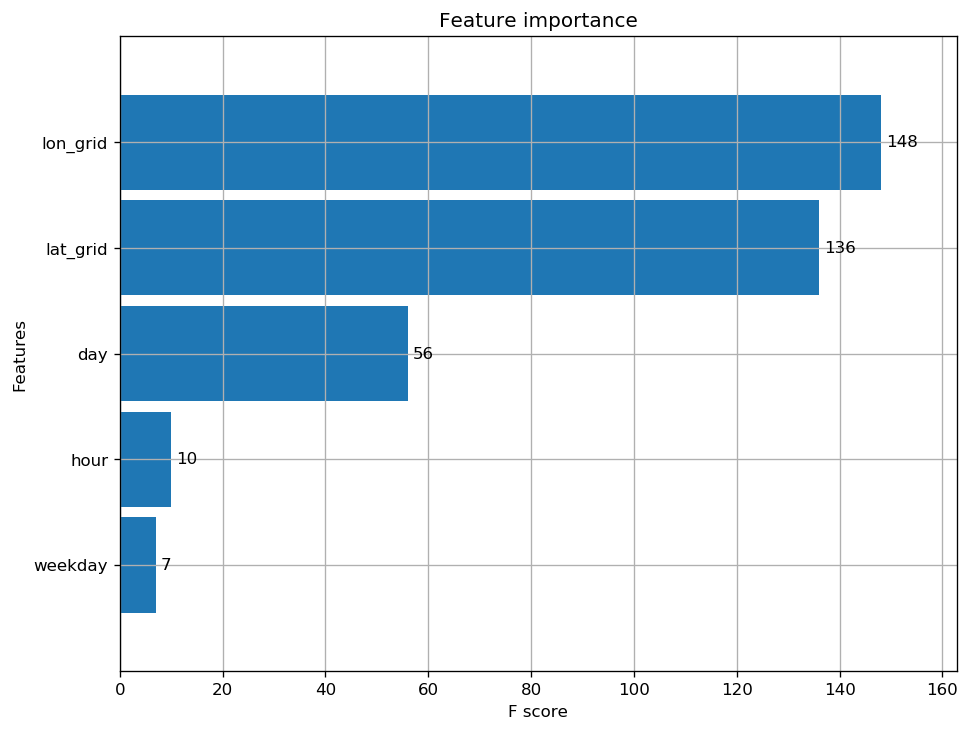

In [337]:
_ = plot_importance(reg, height=0.9)

In [338]:
xgb_result = reg.predict(x_test_)

In [340]:
xgb_result

array([0.59247017, 0.59247017, 0.6501407 , ..., 0.6240619 , 0.59247017,
       0.6240619 ], dtype=float32)

In [372]:
len(xgb_result)

3258864

In [341]:
y_test__

,dattim,lat_grid,lon_grid,maid_unique_count
0,2019-09-23 00:00:00,40.618,-73.964,0.0
1,2019-09-23 00:00:00,40.657,-73.793,0.0
2,2019-09-23 00:00:00,40.719,-74.007,0.0
3,2019-09-23 00:00:00,40.740,-73.985,0.0
4,2019-09-23 00:00:00,40.740,-73.986,0.0
...,...,...,...,...
3258859,2019-09-23 23:50:00,33.848,-117.880,0.0
3258860,2019-09-23 23:50:00,33.896,-118.240,0.0
3258861,2019-09-23 23:50:00,34.025,-118.450,0.0
3258862,2019-09-23 23:50:00,34.116,-118.170,0.0


In [344]:
mean_squared_error(y_true=y_test__['maid_unique_count'],
                   y_pred=xgb_result)

0.5835885227255264

In [ ]:
#calculate campaign 1424 exposed maids using the xgb result

In [384]:
campaign_1424.columns

Index(['maid', 'idType', 'timestamp', 'lat', 'lon', 'mediaId', 'datetime',
       'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'weekday', 'weekofyear', 'bounding_city', 'bounding_city_corr',
       'minuteover10', 'every10minutes', 'dattim'],
      dtype='object')

In [385]:
campaign_1424.head()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,...,hour,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr,minuteover10,every10minutes,dattim
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02,2019-09-20,07:15:02,2019,...,7,15,2,4,38,Los Angeles,Los Angeles,1.5,2,2019-09-20 07:15:00
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,...,21,52,16,4,38,Los Angeles,Los Angeles,5.2,6,2019-09-20 21:52:00
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,...,21,52,16,4,38,Los Angeles,Los Angeles,5.2,6,2019-09-20 21:52:00
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31,2019-09-25,23:59:31,2019,...,23,59,31,2,39,Los Angeles,Los Angeles,5.9,6,2019-09-25 23:59:00
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22,2019-09-27,02:21:22,2019,...,2,21,22,4,39,Los Angeles,Los Angeles,2.1,3,2019-09-27 02:21:00


In [386]:
#find active lat-lon pairs of campaign 1424 up until 23 sept

In [389]:
campaign_1424_activeloc=campaign_1424.loc[(campaign_1424['datetime'] > datetime.strptime('2019-09-23 00:00:00', "%Y-%m-%d %H:%M:%S"))]

In [392]:
campaign_1424_activeloc.columns

Index(['maid', 'idType', 'timestamp', 'lat', 'lon', 'mediaId', 'datetime',
       'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'weekday', 'weekofyear', 'bounding_city', 'bounding_city_corr',
       'minuteover10', 'every10minutes', 'dattim'],
      dtype='object')

In [393]:
campaign_1424_activeloc['latlon_grid'] = campaign_1424_activeloc['lat'].map(lambda x: '{:.05g}'.format(x)) + ' || '+ campaign_1424_activeloc['lon'].map(lambda x: '{:.05g}'.format(x))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [394]:
campaign_1424_activeloc.columns

Index(['maid', 'idType', 'timestamp', 'lat', 'lon', 'mediaId', 'datetime',
       'date', 'time', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'weekday', 'weekofyear', 'bounding_city', 'bounding_city_corr',
       'minuteover10', 'every10minutes', 'dattim', 'latlon_grid'],
      dtype='object')

In [395]:
campaign_1424_activeloc_=campaign_1424_activeloc.latlon_grid.unique()


In [396]:
campaign_1424_activeloc_

array(['33.818 || -118', '34.062 || -118.24', '34.073 || -118.38', ...,
       '34.2 || -118.22', '33.86 || -118.18', '33.759 || -118'],
      dtype=object)

In [435]:
campaign_1424_activeloc_.shape

(16240,)

In [414]:
#filter xgb result with active locations for 1424

filterforresult = y_test__

In [415]:
filterforresult.shape

(3258864, 5)

In [416]:
len(xgb_result)

3258864

In [417]:
type(xgb_result)

numpy.ndarray

In [419]:
xr=pd.DataFrame(data=xgb_result)
filterforresult['xgb_pred']=xr[0]

In [420]:
filterforresult.shape

(3258864, 6)

In [421]:
filterforresult['latlon_grid'] = filterforresult['lat_grid'].map(lambda x: '{:.05g}'.format(x)) + ' || '+ filterforresult['lon_grid'].map(lambda x: '{:.05g}'.format(x))

In [422]:
filterforresult_=filterforresult[filterforresult['latlon_grid'].isin(campaign_1424_activeloc_)]


In [431]:
filterforresult_.shape

(1444896, 6)

In [423]:
filterforresult_.head()

,dattim,lat_grid,lon_grid,maid_unique_count,latlon_grid,xgb_pred
7147,2019-09-23,33.759,-118.02,0.0,33.759 || -118.02,0.592470
7148,2019-09-23,34.018,-118.29,0.0,34.018 || -118.29,0.624062
7149,2019-09-23,34.042,-118.25,0.0,34.042 || -118.25,0.624062
7151,2019-09-23,34.208,-118.39,0.0,34.208 || -118.39,0.624062
7153,2019-09-23,33.672,-117.95,0.0,33.672 || -117.95,0.592470


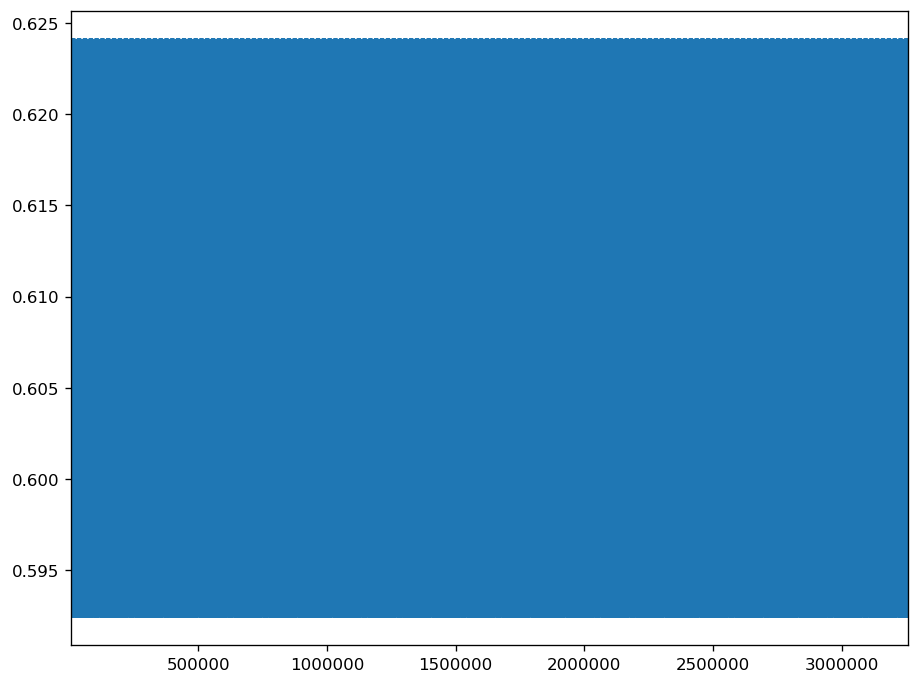

In [430]:
filterforresult_['xgb_pred'].plot()

In [424]:
filterforresult_.shape

(1444896, 6)

In [432]:
filterforresult_.columns

Index(['dattim', 'lat_grid', 'lon_grid', 'maid_unique_count', 'latlon_grid',
       'xgb_pred'],
      dtype='object')

In [433]:
filterforresult_.dattim.nunique()

144

In [434]:
filterforresult_.latlon_grid.nunique()

10034

In [439]:
a=filterforresult_.head(100)
a_=pd.DataFrame(a["xgb_pred"].groupby([a['dattim']]).sum()).reset_index()
a

,dattim,lat_grid,lon_grid,maid_unique_count,latlon_grid,xgb_pred
7147,2019-09-23,33.759,-118.02,0.0,33.759 || -118.02,0.592470
7148,2019-09-23,34.018,-118.29,0.0,34.018 || -118.29,0.624062
7149,2019-09-23,34.042,-118.25,0.0,34.042 || -118.25,0.624062
7151,2019-09-23,34.208,-118.39,0.0,34.208 || -118.39,0.624062
7153,2019-09-23,33.672,-117.95,0.0,33.672 || -117.95,0.592470
...,...,...,...,...,...,...
7263,2019-09-23,33.920,-118.08,0.0,33.92 || -118.08,0.592470
7264,2019-09-23,33.920,-118.21,0.0,33.92 || -118.21,0.592470
7265,2019-09-23,33.924,-118.25,0.0,33.924 || -118.25,0.624062
7266,2019-09-23,33.925,-118.09,0.0,33.925 || -118.09,0.592470


In [425]:
campaign_1424_xgb=pd.DataFrame(filterforresult_["xgb_pred"].groupby([filterforresult_['dattim']]).sum()).reset_index()


In [426]:
campaign_1424_xgb

,dattim,xgb_pred
0,2019-09-23 00:00:00,6092.347168
1,2019-09-23 00:10:00,6092.347168
2,2019-09-23 00:20:00,6092.347168
3,2019-09-23 00:30:00,6092.347168
4,2019-09-23 00:40:00,6092.347168
...,...,...
139,2019-09-23 23:10:00,6092.347168
140,2019-09-23 23:20:00,6092.347168
141,2019-09-23 23:30:00,6092.347168
142,2019-09-23 23:40:00,6092.347168


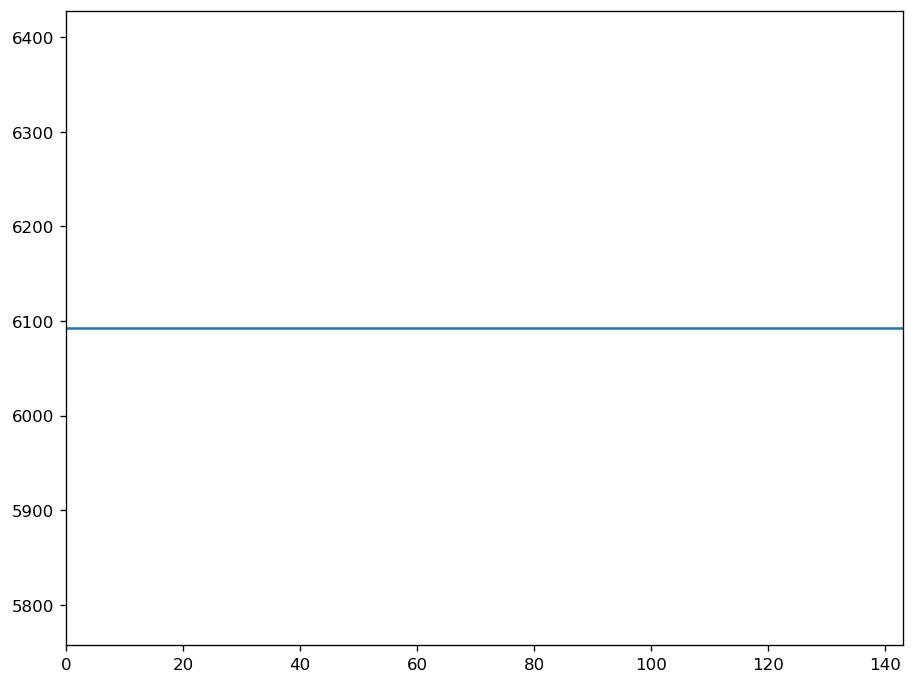

In [428]:
campaign_1424_xgb['xgb_pred'].plot()

In [507]:
print(mape(campaign_1424_ts_test.maid,campaign_1424_xgb.xgb_pred))
print(med_ape(campaign_1424_ts_test.maid,campaign_1424_xgb.xgb_pred))

6655.8697654262005
3559.3643703708394


### Apply Selected Model Prophet to Each Campaign 

In [609]:
def apply_prophet(cmp_id,train_st,train_end,test_st,test_end):

    cmp_id['minuteover10']=(cmp_id ['minute'])/10
    cmp_id['every10minutes']=cmp_id['minuteover10'].apply(np.floor).astype(int)+1

    dtfreqsc = pd.Series()

    i=0
    for result in perdelta(
        datetime.strptime(train_st, '%Y-%m-%d %H:%M:%S'),
        datetime.strptime(test_end, '%Y-%m-%d %H:%M:%S'),
        timedelta(minutes=10)):

        dtfreqsc = dtfreqsc.set_value(i,result)
        i=i+1

    dtfreqsc_frame=dtfreqsc.to_frame()
    dtfreqsc_frame.rename(columns={0:'dattim'},inplace=True)

    cmp_id_ts = pd.DataFrame(cmp_id["maid"].groupby([cmp_id['date'], cmp_id['year'], cmp_id['month'],
    cmp_id['day'], cmp_id['hour'], cmp_id['every10minutes']]).nunique()).reset_index()
    cmp_id_ts['minute']=(cmp_id_ts['every10minutes']-1)*10#minute for 10 min intervals
    cmp_id_ts['dattim']=pd.to_datetime(cmp_id_ts[['year','month','day','hour','minute']])
    cmp_id_ts.sort_values(by=['dattim'], ascending=True,inplace=True)

    cmp_id_ts_data = pd.merge(dtfreqsc_frame,
                     cmp_id_ts[['dattim','maid']],
                     on='dattim', 
                     how='left')

    cmp_id_ts_data.sort_values(by=['dattim'], ascending=True,inplace=True)

    cmp_id_ts_data.fillna(0,inplace=True)

    cmp_id_ts_test=cmp_id_ts_data[(cmp_id_ts_data['dattim'] >= test_st) & (cmp_id_ts_data['dattim'] < test_end)]
    cmp_id_ts_test

    cmp_id_ts_train=cmp_id_ts_data[(cmp_id_ts_data['dattim'] <= train_end)]

    cmp_id_ts_test.set_index('dattim', inplace=True)

    cmp_id_ts_train.set_index('dattim', inplace=True)

    cmp_id_ts_train_prophet=cmp_id_ts_train
    cmp_id_ts_train_prophet["dts"] = cmp_id_ts_train_prophet.index
    cmp_id_ts_train_prophet["ds"] = cmp_id_ts_train_prophet["dts"].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))


    cmp_id_ts_train_prophet.drop(['dts'],axis=1,inplace=True)
    cmp_id_ts_train_prophet.rename(columns={'maid':'y'},inplace=True)

    model=Prophet(interval_width=0.85,daily_seasonality=True)
    model=model.fit(cmp_id_ts_train_prophet)

    cmp_id_ts_test_prophet=cmp_id_ts_test
    cmp_id_ts_test_prophet["dts"] = cmp_id_ts_test_prophet.index
    cmp_id_ts_test_prophet["ds"] = cmp_id_ts_test_prophet["dts"].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
    cmp_id_ts_test_prophet.drop(['dts'],axis=1,inplace=True)
    cmp_id_ts_test_prophet.drop(['maid'],axis=1,inplace=True)

    forecast_cmp_id_ts_test_prophet=model.predict(cmp_id_ts_test_prophet)
    forecast_cmp_id_ts_test_prophet

    cmp_id_ts_test=cmp_id_ts_data[(cmp_id_ts_data['dattim'] >= test_st) & (cmp_id_ts_data['dattim'] < test_end)]
    cmp_id_ts_test.set_index('dattim', inplace=True)

    yhat_forecast_cmp_id_prophet=forecast_cmp_id_ts_test_prophet[['ds','yhat','yhat_lower']]
    yhat_forecast_cmp_id_prophet.set_index('ds', inplace=True)

    print(mape(cmp_id_ts_test.maid,yhat_forecast_cmp_id_prophet.yhat))
    print(med_ape(cmp_id_ts_test.maid,yhat_forecast_cmp_id_prophet.yhat))
    print(cmp_id_ts_test.maid.mean())
    print(cmp_id_ts_test.maid.median())
    
    print('\n\n')
    
    #make negatives zero
    yhat_forecast_cmp_id_prophet['prediction']=(yhat_forecast_cmp_id_prophet['yhat_lower']+yhat_forecast_cmp_id_prophet['yhat'])/2

    yhat_forecast_cmp_id_prophet['prediction'][yhat_forecast_cmp_id_prophet['prediction']< 0] = 0
    
    print(mape(cmp_id_ts_test.maid,yhat_forecast_cmp_id_prophet.prediction))
    print(med_ape(cmp_id_ts_test.maid,yhat_forecast_cmp_id_prophet.prediction))
    
    print(cmp_id_ts_test.maid.sum())
    print(yhat_forecast_cmp_id_prophet.prediction.sum())


In [610]:
#split the dataset for each campaign
campaign_1424 = maids_0and1_unique.loc[(maids_0and1_unique['mediaId']=="1424")]
campaign_1424.head()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,...,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr,latlon_grid,latlon,minuteover10,every10minutes
0,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1568963702000,33.817857,-118.002630,1424,2019-09-20 07:15:02,2019-09-20,07:15:02,2019,...,15,2,4,38,Los Angeles,Los Angeles,33.818 || -118,33.817857000000004 || -118.00263000000001,1.5,2
3,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803810,-117.941540,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,...,52,16,4,38,Los Angeles,Los Angeles,33.804 || -117.94,33.80381 || -117.94153999999999,5.2,6
4,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569016336000,33.803811,-117.941547,1424,2019-09-20 21:52:16,2019-09-20,21:52:16,2019,...,52,16,4,38,Los Angeles,Los Angeles,33.804 || -117.94,33.803810999999996 || -117.941547,5.2,6
5,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569455971000,33.817865,-118.002630,1424,2019-09-25 23:59:31,2019-09-25,23:59:31,2019,...,59,31,2,39,Los Angeles,Los Angeles,33.818 || -118,33.817865000000005 || -118.00263000000001,5.9,6
6,00003f94-b688-4969-bd7a-42f9e9a82701,adid,1569550882000,33.817875,-118.002660,1424,2019-09-27 02:21:22,2019-09-27,02:21:22,2019,...,21,22,4,39,Los Angeles,Los Angeles,33.818 || -118,33.817875 || -118.00266,2.1,3


In [611]:

campaign_1424_prophet=apply_prophet(campaign_1424,"2019-09-18 21:20:00","2019-09-25 22:50:00","2019-09-25 23:00:00","2019-09-28 22:00:00")


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or

373.3341739645764
94.93339526420661
85.53051643192488
68.0



236.55087642593006
67.77152001784212
36436.0
49259.386195119216


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [612]:
#split the dataset for each campaign
campaign_02D0 = maids_0and1_unique.loc[(maids_0and1_unique['mediaId']=="02D09F56EBDEB6")]
campaign_02D0.head()

,maid,idType,timestamp,lat,lon,mediaId,datetime,date,time,year,...,minute,second,weekday,weekofyear,bounding_city,bounding_city_corr,latlon_grid,latlon,minuteover10,every10minutes
8,0000b601-def1-4508-9b90-c1696477f31c,idfa,1569338467000,40.714500,-74.002899,02D09F56EBDEB6,2019-09-24 15:21:07,2019-09-24,15:21:07,2019,...,21,7,1,39,New York,New York,40.715 || -74.003,40.7145004272 || -74.0028991699,2.1,3
9,0000b601-def1-4508-9b90-c1696477f31c,idfa,1569338475000,40.714500,-74.002899,02D09F56EBDEB6,2019-09-24 15:21:15,2019-09-24,15:21:15,2019,...,21,15,1,39,New York,New York,40.715 || -74.003,40.7145004272 || -74.0028991699,2.1,3
24,00016983-b43b-48b0-9fcb-004552d8f39b,adid,1568909855000,40.749098,-73.986305,02D09F56EBDEB6,2019-09-19 16:17:35,2019-09-19,16:17:35,2019,...,17,35,3,38,New York,New York,40.749 || -73.986,40.7490982 || -73.9863052,1.7,2
25,00016983-b43b-48b0-9fcb-004552d8f39b,adid,1568909863000,40.749098,-73.986305,02D09F56EBDEB6,2019-09-19 16:17:43,2019-09-19,16:17:43,2019,...,17,43,3,38,New York,New York,40.749 || -73.986,40.7490982 || -73.9863052,1.7,2
26,00016983-b43b-48b0-9fcb-004552d8f39b,adid,1568909900000,40.749098,-73.986305,02D09F56EBDEB6,2019-09-19 16:18:20,2019-09-19,16:18:20,2019,...,18,20,3,38,New York,New York,40.749 || -73.986,40.7490982 || -73.9863052,1.8,2


In [614]:
campaign_02D0_prophet=apply_prophet(campaign_02D0,"2019-09-17 11:00:00","2019-09-25 18:00:00","2019-09-25 18:10:00","2019-09-28 18:10:00")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or

268.6870625934102
122.56969959927555
74.04166666666667
0.0



159.61919743190256
26.558579828965044
31986.0
58514.44583056411


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [615]:
campaign_0494_prophet=apply_prophet(campaign_0494,"2019-09-10 11:00:00","2019-09-21 11:40:00","2019-09-21 11:50:00","2019-09-24 11:50:00")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or

48.502047075447656
25.859128810066988
102.77777777777777
0.0



24.765545754441796
0.0
44400.0
28661.751924441818


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [624]:
def predict_prophet(cmp_id,train_st,train_end,test_st,test_end):

    cmp_id['minuteover10']=(cmp_id ['minute'])/10
    cmp_id['every10minutes']=cmp_id['minuteover10'].apply(np.floor).astype(int)+1

    dtfreqsc = pd.Series()

    i=0
    for result in perdelta(
        datetime.strptime(train_st, '%Y-%m-%d %H:%M:%S'),
        datetime.strptime(test_end, '%Y-%m-%d %H:%M:%S'),
        timedelta(minutes=10)):

        dtfreqsc = dtfreqsc.set_value(i,result)
        i=i+1

    dtfreqsc_frame=dtfreqsc.to_frame()
    dtfreqsc_frame.rename(columns={0:'dattim'},inplace=True)

    cmp_id_ts = pd.DataFrame(cmp_id["maid"].groupby([cmp_id['date'], cmp_id['year'], cmp_id['month'],
    cmp_id['day'], cmp_id['hour'], cmp_id['every10minutes']]).nunique()).reset_index()
    cmp_id_ts['minute']=(cmp_id_ts['every10minutes']-1)*10#minute for 10 min intervals
    cmp_id_ts['dattim']=pd.to_datetime(cmp_id_ts[['year','month','day','hour','minute']])
    cmp_id_ts.sort_values(by=['dattim'], ascending=True,inplace=True)

    cmp_id_ts_data = pd.merge(dtfreqsc_frame,
                     cmp_id_ts[['dattim','maid']],
                     on='dattim', 
                     how='left')

    cmp_id_ts_data.sort_values(by=['dattim'], ascending=True,inplace=True)

    cmp_id_ts_data.fillna(0,inplace=True)

    cmp_id_ts_test=cmp_id_ts_data[(dtfreqsc_frame['dattim'] >= datetime.strptime(test_st,"%Y-%m-%d %H:%M:%S")) & (dtfreqsc_frame['dattim'] < datetime.strptime(test_end,"%Y-%m-%d %H:%M:%S"))]

    cmp_id_ts_train=cmp_id_ts_data[(cmp_id_ts_data['dattim'] <= train_end)]

    cmp_id_ts_test.set_index('dattim', inplace=True)

    cmp_id_ts_train.set_index('dattim', inplace=True)

    cmp_id_ts_train_prophet=cmp_id_ts_train
    cmp_id_ts_train_prophet["dts"] = cmp_id_ts_train_prophet.index
    cmp_id_ts_train_prophet["ds"] = cmp_id_ts_train_prophet["dts"].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))


    cmp_id_ts_train_prophet.drop(['dts'],axis=1,inplace=True)
    cmp_id_ts_train_prophet.rename(columns={'maid':'y'},inplace=True)
    
    model=Prophet(interval_width=0.85,daily_seasonality=True)
    model=model.fit(cmp_id_ts_train_prophet)

    cmp_id_ts_test_prophet=cmp_id_ts_test
    cmp_id_ts_test_prophet["dts"] = cmp_id_ts_test_prophet.index
    cmp_id_ts_test_prophet["ds"] = cmp_id_ts_test_prophet["dts"].apply(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
    cmp_id_ts_test_prophet.drop(['dts'],axis=1,inplace=True)
    cmp_id_ts_test_prophet.drop(['maid'],axis=1,inplace=True)

    forecast_cmp_id_ts_test_prophet=model.predict(cmp_id_ts_test_prophet)

    cmp_id_ts_test=cmp_id_ts_data[(cmp_id_ts_data['dattim'] >= test_st) & (cmp_id_ts_data['dattim'] < test_end)]
    cmp_id_ts_test.set_index('dattim', inplace=True)

    yhat_forecast_cmp_id_prophet=forecast_cmp_id_ts_test_prophet[['ds','yhat','yhat_lower']]
    yhat_forecast_cmp_id_prophet.set_index('ds', inplace=True)
    

    yhat_forecast_cmp_id_prophet['meanofyhatandlower']=(yhat_forecast_cmp_id_prophet['yhat_lower']+yhat_forecast_cmp_id_prophet['yhat'])/2

    #make negatives zero
    yhat_forecast_cmp_id_prophet['meanofyhatandlower'][yhat_forecast_cmp_id_prophet['meanofyhatandlower']< 0] = 0
    yhat_forecast_cmp_id_prophet['yhat'][yhat_forecast_cmp_id_prophet['yhat']< 0] = 0
    yhat_forecast_cmp_id_prophet['yhat_lower'][yhat_forecast_cmp_id_prophet['yhat_lower']< 0] = 0
    
    return yhat_forecast_cmp_id_prophet

In [625]:
campaign_0494_prophet_forecast=predict_prophet(campaign_0494,"2019-09-10 11:00:00","2019-09-24 11:50:00","2019-09-24 12:00:00","2019-10-01 12:00:00")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or

In [626]:
campaign_0494_prophet_forecast

,yhat,yhat_lower,meanofyhatandlower
ds,,,
2019-09-24 12:00:00,185.038605,64.573551,124.806078
2019-09-24 12:10:00,196.545732,69.827935,133.186834
2019-09-24 12:20:00,207.996426,92.723907,150.360166
2019-09-24 12:30:00,219.400193,94.305065,156.852629
2019-09-24 12:40:00,230.765189,111.394457,171.079823
...,...,...,...
2019-10-01 11:10:00,139.217290,21.394710,80.306000
2019-10-01 11:20:00,151.020458,29.188229,90.104344
2019-10-01 11:30:00,162.785811,47.085580,104.935696


In [628]:
campaign_0494_prophet_forecast.to_csv('campaign_0492_prophet_forecast_10min.csv')

In [629]:
campaign_0494_prophet_forecast.meanofyhatandlower.sum()

83620.99066745013

In [631]:
campaign_1424_prophet_forecast=predict_prophet(campaign_0494,"2019-09-10 11:00:00","2019-09-24 11:50:00","2019-09-24 12:00:00","2019-10-01 12:00:00")
campaign_1424_prophet_forecast.to_csv('campaign_1424_prophet_forecast_10min.csv')
campaign_1424_prophet_forecast.yhat_lower.sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or

59884.4451330489

In [632]:
campaign_02D0_prophet_forecast=predict_prophet(campaign_0494,"2019-09-10 11:00:00","2019-09-24 11:50:00","2019-09-24 12:00:00","2019-10-01 12:00:00")
campaign_02D0_prophet_forecast.to_csv('campaign_02D0_prophet_forecast_10min.csv')
campaign_02D0_prophet_forecast.yhat_lower.sum()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or

60002.54230901652